In [190]:
# Import some basic python packages
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.ascii as ascii # to help with reading in data later
import math
##Scipy Optimise##
from scipy.optimize import curve_fit 

# Next line is makes plots conveniently appear in this notebook
%matplotlib inline

In [191]:
# Read in the two dataset:
data1 = ascii.read('part1_dataset1_2.dat')
data2 = ascii.read('part1_dataset2_2.dat')

# Print out what the three different columns inside the data set are:
print(data1.colnames)
print(data2.colnames)

# Calculate time interval 
T_interval1 = np.array(data1['Time'][-1]/(np.shape(data1)[0]-1))
T_interval2 = np.array(data2['Time'][-1]/(np.shape(data2)[0]-1))

# Convert Detector Count per time interval to Detector Count per second for first data set and saving to variable
R1 = np.array(data1['R1'] / T_interval1)
R2 = np.array(data1['R2'] / T_interval1)
R3 = np.array(data1['R3'] / T_interval1)
R4 = np.array(data1['R4'] / T_interval1)
e_R1 = np.array(data1['e_R1'] / T_interval1)
e_R2 = np.array(data1['e_R2'] / T_interval1)
e_R3 = np.array(data1['e_R3'] / T_interval1)
e_R4 = np.array(data1['e_R4'] / T_interval1)

# Convert Detector Count per time interval to Detector Count per second for second data set and saving to variable
R1_2 = np.array(data2['R1'] / T_interval2)
R2_2 = np.array(data2['R2'] / T_interval2)
R3_2 = np.array(data2['R3'] / T_interval2)
R4_2 = np.array(data2['R4'] / T_interval2)
e_R1_2 = np.array(data2['e_R1'] / T_interval2)
e_R2_2 = np.array(data2['e_R2'] / T_interval2)
e_R3_2 = np.array(data2['e_R3'] / T_interval2)
e_R4_2 = np.array(data2['e_R4'] / T_interval2)

# Save recorded Time to variable for each data set
t = np.array(data1['Time'])
t_2 = np.array(data2['Time'])


['Time', 'R1', 'e_R1', 'R2', 'e_R2', 'R3', 'e_R3', 'R4', 'e_R4']
['Time', 'R1', 'e_R1', 'R2', 'e_R2', 'R3', 'e_R3', 'R4', 'e_R4']


In [192]:
### ALL FUNCTIONS USED IN PROGRAM ###
######################################################################################
'''
WeightedLeastSquares:  
         function to calculate a linear weighted least squares model for a given dataset

Inputs:
x      - measured values of x (numpy array)
y      - measured values of y (numpy array)
e_y    - errors associated with measured values of y (numpy array)

Outputs:
m   - returns the modelled gradient (float)
c   - returns the modelled intercept (float)
'''
# Weighted least squares function
def WeightedLeastSquares(x, y, e_y):
    
    s = np.sum(1/e_y**2)

    s_x = np.sum(x/e_y**2)
    s_y = np.sum(y/e_y**2)
    s_xy = np.sum((x*y)/e_y**2)
    s_xx = np.sum((x**2)/e_y**2)

    m = (s*s_xy - s_x*s_y) / (s*s_xx - s_x**2)
    c = (s_xx*s_y - s_x*s_xy) / (s*s_xx - s_x**2)
    
    
    return m, c
######################################################################################
'''
BootStrap:  
         function to carry out a bootstrap analysis for a given model

Inputs:
residuals - residuals calculated for a given model (numpy array)
x      - measured values of x (numpy array)
m      - modelled gradient (float)
c      - modelled intercept (float)
e_y    - errors associated with measured values of y (numpy array)
iterations - number of iterations for bootstrap to run (int)

Outputs:
BS_m   - returns the gradient calculated at each bootstrap iteration (numpy array)
BS_c   - returns the intercept calculated at each bootstrap iteration (numpy array)
'''
# Bootsrap analysis function
def BootStrap(residuals, x, m, c, e_y, iterations):
    
    N = np.shape(residuals)[0]
    BS_m = np.zeros(iterations)
    BS_c = np.zeros (iterations)

    for j in range(0, iterations):
        temp_residuals = np.zeros(N)
        temp_y = np.zeros(N)
        temp_e_y = np.zeros(N)
        
        position = np.random.randint(0, N, N)

        for i in range(0, N):
            temp_residuals[i] = residuals[position[i]]
            temp_e_y[i] = e_y[position[i]]

        temp_y = m*x + c + temp_residuals
        BS_m[j], BS_c[j] = WeightedLeastSquares(x, temp_y, temp_e_y)
    
    return BS_m, BS_c
######################################################################################
'''
ChiSquared:  
         function to calculate the Chi Squared value for a given model

Inputs:
fx     - modelled values of y (numpy array)
y      - measured values of y (numpy array)
e_y    - erros associated with measured values of y (numpy array)

Outputs:
chi_sq - returns the Chi Squared value associated with the inputs (float)
'''
def ChiSquared(fx, y, e_y):
    
    chi_sq = np.sum((y-fx)**2 / e_y**2)
    
    return chi_sq
######################################################################################
'''
AIC_BIC:  
         function to calculate the corrected Akaike Information Criterion (AIC) and
         Bayesian Information Criterion (BIC) values for a given Chi Squared

Inputs:
chi_sq - the Chi Squared value to be checked (float)
N      - the number of data points (int)
p      - the number of model parameters (int)

Outputs:
return - activity of the isotope as a function of time (numpy array)
'''
def AIC_BIC(chi_sq, N, p):
    return chi_sq + 2*p + (2*p*(p+1))/(N-p-1), chi_sq + np.log(N)*p
######################################################################################
'''
SingleIsotope:  
         function to calculate the activity of an isotope as a function of time

Inputs:
t      - the time value (numpy array)
a      - activity at t=0 the isotope (float)
b      - decay constant of the isotope (float)

Outputs:
return - activity of the isotope as a function of time (numpy array)
'''
def SingleIsotope(t, a, b):
    return a*np.exp(-b*t)
######################################################################################
'''
DoubleIsotope: 
         function to calculate the activity of two isotopes as a function of time

Inputs:
t      - the time value (numpy array)
a1     - activity at t=0 of first isotope (float)
a2     - activity at t=0 of second isotope (float)
b1     - decay constant of first isotope (float)
b2     - decay constant of second isotope (float)

Outputs:
return - combined activity of the two isotopes as a function of time (numpy array)
'''
def DoubleIsotope(t, a1, a2, b1, b2):
    return (a1*np.exp(-b1*t) + a2*np.exp(-b2*t))
######################################################################################
'''
DoubleIsotopeMCMC: 
         function to calculate the activity of two isotopes as a function of time. This 
         function is the same as DoubleIsotope() however, it takes its parameters in as
         an array rather than separate variables

Inputs:
t      - the time value (numpy array)
params - array containing the 4 parameters used in the function (numpy array)

Outputs:
return - combined activity of the two isotopes as a function of time (numpy array)
'''
def DoubleIsotopeMCMC(t, params):
    return (params[0]*np.exp(-params[2]*t) + params[1]*np.exp(-params[3]*t))
######################################################################################
'''
mcmc:    function to perform a simple MCMC using the Metropolis-Hastings Algorithm

Inputs:
func   - the function to be used for fitting. Function should accept 2 inputs
         the first is the x-values at which the model is calculated, the second
         is a numpy array for the parameters.
x      - the x-values at which the model should be calculated (numpy array)
y      - the value of the data for each x (numpy array)
sig    - the uncertainty on y (numpy array)
pars0  - The initial paramters from which to start the MCMC chain (numpy array)
stepsize - the stepsize for each of the parameters (numpy array)
nstep  - the number of steps in the MCMC chain

Outputs:
chain  - The MCMC chain as a (Nsteps, Npars) (numpy array)
'''
def mcmc(func,x,y,sig,pars0,stepsize,nstep=1e4):
    nstep=int(nstep)
    npars=pars0.shape[0]
    chain=np.zeros((int(nstep),npars))
    chi2=np.zeros(int(nstep))

    chain[0,:]=pars0.copy()
    mdl=func(x,pars0)
    chi2[0]=np.sum( (y-mdl)**2/sig**2)
    njump=0
    for i in range(1,nstep):
        pars_new=np.random.normal(chain[i-1,:],stepsize)
        mdl=func(x,pars_new)
        chi2_new=np.sum( (y-mdl)**2/sig**2)
        if (chi2_new > chi2[i-1]):
            p0=np.exp(-(chi2_new-chi2[i-1])/2.)
            p=np.random.uniform(0,1,1)
            if  p<=p0:
                chain[i,:]=pars_new
                chi2[i]=chi2_new
                njump=njump+1
            else:
                chain[i,:]=chain[i-1,:]
                chi2[i]=chi2[i-1]
        else:
            chain[i,:]=pars_new
            njump=njump+1
            chi2[i]=chi2_new
    print('Jump fraction: %.3f' %(njump/nstep))
    return chain

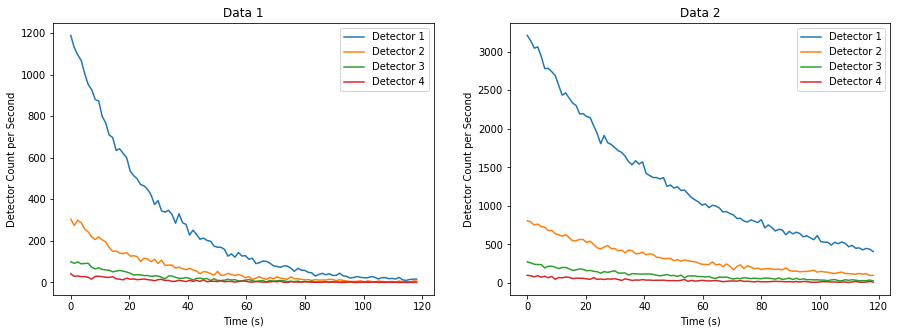

In [193]:
# Plot both data sets
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(t, R1,
        t, R2,
        t, R3,
        t, R4)
plt.ylabel('Detector Count per Second')
plt.xlabel('Time (s)')
plt.title('Data 1')
plt.legend(['Detector 1', 'Detector 2', 'Detector 3', 'Detector 4'])

plt.subplot(1,2,2)
plt.plot(t_2, R1_2,
        t_2, R2_2,
        t_2, R3_2,
        t_2, R4_2)
plt.ylabel('Detector Count per Second')
plt.xlabel('Time (s)')
plt.title('Data 2')
plt.legend(['Detector 1', 'Detector 2', 'Detector 3', 'Detector 4'])

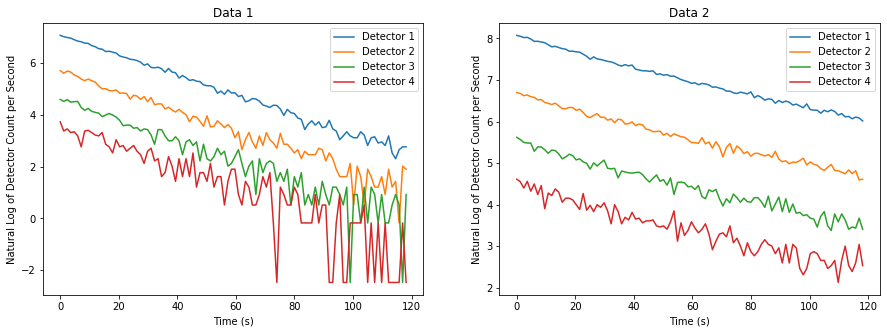

In [194]:
# Take natural log of detector counts for both datasets
R1_ln = np.log(R1)
R2_ln = np.log(R2)
R3_ln = np.log(R3)
R4_ln = np.log(R4)
R1_2_ln = np.log(R1_2)
R2_2_ln = np.log(R2_2)
R3_2_ln = np.log(R3_2)
R4_2_ln = np.log(R4_2)

# Propagate errors for natural log
e_R1_ln = e_R1 / R1
e_R2_ln = e_R2 / R2
e_R3_ln = e_R3 / R3
e_R4_ln = e_R4 / R4
e_R1_2_ln = e_R1_2 / R1_2
e_R2_2_ln = e_R2_2 / R2_2
e_R3_2_ln = e_R3_2 / R3_2
e_R4_2_ln = e_R4_2 / R4_2


# Plot log of detector count
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(t, R1_ln,
        t, R2_ln,
        t, R3_ln,
        t, R4_ln)
plt.ylabel('Natural Log of Detector Count per Second')
plt.xlabel('Time (s)')
plt.title('Data 1')
plt.legend(['Detector 1', 'Detector 2', 'Detector 3', 'Detector 4'])

plt.subplot(1,2,2)
plt.plot(t_2, R1_2_ln,
        t_2, R2_2_ln,
        t_2, R3_2_ln,
        t_2, R4_2_ln)
plt.ylabel('Natural Log of Detector Count per Second')
plt.xlabel('Time (s)')
plt.title('Data 2')
plt.legend(['Detector 1', 'Detector 2', 'Detector 3', 'Detector 4'])

In [195]:
# Perform Weighted Least Squares function for each detector
m1, c1 = WeightedLeastSquares(t, R1_ln, e_R1_ln)
m2, c2 = WeightedLeastSquares(t, R2_ln, e_R2_ln)
m3, c3 = WeightedLeastSquares(t, R3_ln, e_R3_ln)
m4, c4 = WeightedLeastSquares(t, R4_ln, e_R4_ln)

In [196]:
# Calculated and output A0 and Decay Constants using modelled values above
print('DETECTOR 1: Decay Constant:',-m1,'A0:', math.exp(c1))
print('DETECTOR 2: Decay Constant:',-m2,'A0:', math.exp(c2))
print('DETECTOR 3: Decay Constant:',-m3,'A0:', math.exp(c3))
print('DETECTOR 4: Decay Constant:',-m4,'A0:', math.exp(c4))

DETECTOR 1: Decay Constant: 0.03856977847876615 A0: 1206.1903328916717
DETECTOR 2: Decay Constant: 0.038069633996622554 A0: 296.2602317119569
DETECTOR 3: Decay Constant: 0.038027528685734245 A0: 98.0948325052812
DETECTOR 4: Decay Constant: 0.03378546511816315 A0: 34.09527042676313


Text(0.5, 1.0, 'Detector 4')

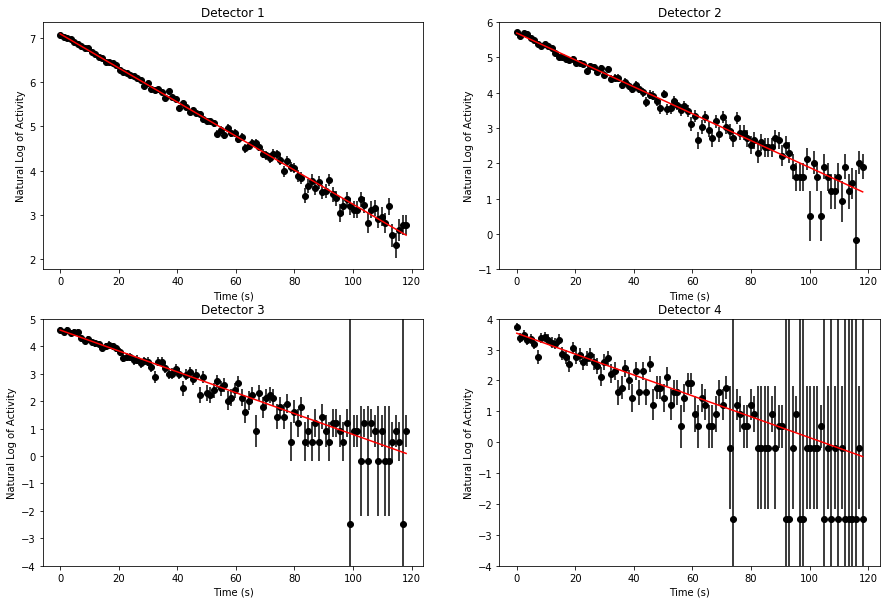

In [197]:
# Plot of data with propagated error bars with weighted least square fitting for each detector
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(t, m1*t+c1, 'r-')
plt.errorbar(t,R1_ln,yerr=e_R1_ln,fmt='ko',zorder=1)
plt.ylabel('Natural Log of Activity')
plt.xlabel('Time (s)')
plt.title('Detector 1')

plt.subplot(2,2,2)
plt.plot(t, m2*t+c2, 'r-')
plt.errorbar(t, R2_ln, yerr=e_R2_ln, fmt='ko', zorder=1)
plt.ylim(-1, 6)
plt.ylabel('Natural Log of Activity')
plt.xlabel('Time (s)')
plt.title('Detector 2')

plt.subplot(2,2,3)
plt.plot(t, m3*t+c3, 'r-')
plt.errorbar(t, R3_ln, yerr=e_R3_ln, fmt='ko', zorder=1)
plt.ylim(-4, 5)
plt.ylabel('Natural Log of Activity')
plt.xlabel('Time (s)')
plt.title('Detector 3')

plt.subplot(2,2,4)
plt.plot(t, m4*t+c4, 'r-')
plt.errorbar(t, R4_ln, yerr=e_R4_ln, fmt='ko', zorder=1)
plt.ylim(-4, 4)
plt.ylabel('Natural Log of Activity')
plt.xlabel('Time (s)')
plt.title('Detector 4')

Text(0.5, 1.0, 'Detector 4')

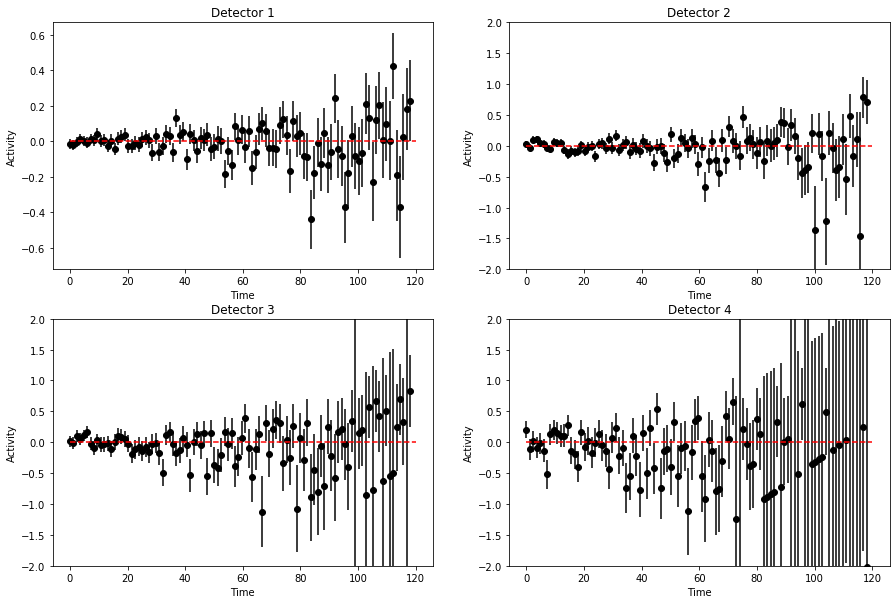

In [198]:
##Plot of Residuals for each detector##
residuals1 = R1_ln-(m1*t + c1)
residuals2 = R2_ln-(m2*t + c2)
residuals3 = R3_ln-(m3*t + c3)
residuals4 = R4_ln-(m4*t + c4)

plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.errorbar(t,residuals1,yerr=e_R1_ln,fmt='ko')
plt.hlines(0, 0, 120, colors='red', linestyles='dashed', zorder=3)
plt.ylabel('Activity')
plt.xlabel('Time')
plt.title('Detector 1')

plt.subplot(2,2,2)
plt.errorbar(t,residuals2,yerr=e_R2_ln,fmt='ko')
plt.hlines(0, 0, 120, colors='red', linestyles='dashed', zorder=3)
plt.ylim(-2, 2)
plt.ylabel('Activity')
plt.xlabel('Time')
plt.title('Detector 2')

plt.subplot(2,2,3)
plt.errorbar(t,residuals3,yerr=e_R3_ln,fmt='ko')
plt.hlines(0, 0, 120, colors='red', linestyles='dashed', zorder=3)
plt.ylim(-2, 2)
plt.ylabel('Activity')
plt.xlabel('Time')
plt.title('Detector 3')

plt.subplot(2,2,4)
plt.errorbar(t,residuals4,yerr=e_R4_ln,fmt='ko')
plt.hlines(0, 0, 120, colors='red', linestyles='dashed', zorder=3)
plt.ylim(-2, 2)
plt.ylabel('Activity')
plt.xlabel('Time')
plt.title('Detector 4')

In [199]:
# Perform bootstrap analysis for each detector
iterations = 10000
BS_m1, BS_c1 = BootStrap(residuals1, t, m1, c1, e_R1_ln, iterations)
BS_m2, BS_c2 = BootStrap(residuals2, t, m2, c2, e_R2_ln, iterations)
BS_m3, BS_c3 = BootStrap(residuals3, t, m3, c3, e_R3_ln, iterations)
BS_m4, BS_c4 = BootStrap(residuals4, t, m4, c4, e_R4_ln, iterations)

Text(0.5, 1.0, 'Detector 4')

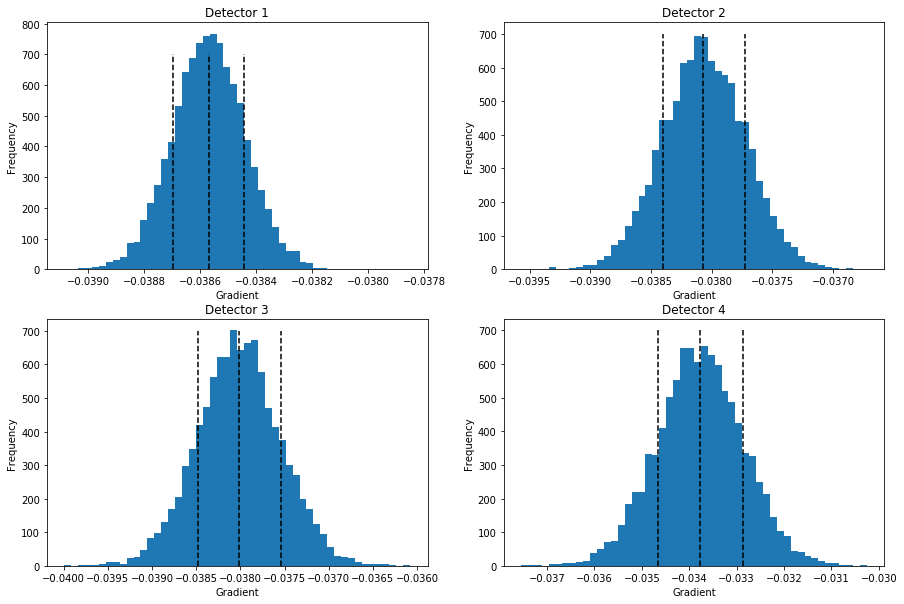

In [200]:
# Calculated median, upper(84%)/lower(16%) Confidence Intervals for bootstrap parameters
median_BS_m1 = np.quantile(BS_m1, 0.5) 
median_BS_m2 = np.quantile(BS_m2, 0.5)
median_BS_m3 = np.quantile(BS_m3, 0.5)
median_BS_m4 = np.quantile(BS_m4, 0.5)

upperCI_BS_m1 = np.quantile(BS_m1, 0.84)
upperCI_BS_m2 = np.quantile(BS_m2, 0.84)
upperCI_BS_m3 = np.quantile(BS_m3, 0.84)
upperCI_BS_m4 = np.quantile(BS_m4, 0.84)

lowerCI_BS_m1 = np.quantile(BS_m1, 0.16)
lowerCI_BS_m2 = np.quantile(BS_m2, 0.16)
lowerCI_BS_m3 = np.quantile(BS_m3, 0.16)
lowerCI_BS_m4 = np.quantile(BS_m4, 0.16)

# Plot histograms with median, upper(84%)/lower(16%) Confidence Intervals for bootstrap parameters
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.hist(BS_m1, 50)
plt.vlines(median_BS_m1, 0, 700, colors='black', linestyles='dashed')
plt.vlines(upperCI_BS_m1, 0, 700, colors='black', linestyles='dashed')
plt.vlines(lowerCI_BS_m1, 0, 700, colors='black', linestyles='dashed')
plt.ylabel('Frequency')
plt.xlabel('Gradient')
plt.title('Detector 1')

plt.subplot(2,2,2)
plt.hist(BS_m2, 50)
plt.vlines(median_BS_m2, 0, 700, colors='black', linestyles='dashed')
plt.vlines(upperCI_BS_m2, 0, 700, colors='black', linestyles='dashed')
plt.vlines(lowerCI_BS_m2, 0, 700, colors='black', linestyles='dashed')
plt.ylabel('Frequency')
plt.xlabel('Gradient')
plt.title('Detector 2')

plt.subplot(2,2,3)
plt.hist(BS_m3, 50)
plt.vlines(median_BS_m3, 0, 700, colors='black', linestyles='dashed')
plt.vlines(upperCI_BS_m3, 0, 700, colors='black', linestyles='dashed')
plt.vlines(lowerCI_BS_m3, 0, 700, colors='black', linestyles='dashed')
plt.ylabel('Frequency')
plt.xlabel('Gradient')
plt.title('Detector 3')

plt.subplot(2,2,4)
plt.hist(BS_m4, 50)
plt.vlines(median_BS_m4, 0, 700, colors='black', linestyles='dashed')
plt.vlines(upperCI_BS_m4, 0, 700, colors='black', linestyles='dashed')
plt.vlines(lowerCI_BS_m4, 0, 700, colors='black', linestyles='dashed')
plt.ylabel('Frequency')
plt.xlabel('Gradient')
plt.title('Detector 4')

In [201]:
# Print bootstrap gradients for each detector with associated uncertainties
print('GRADIENT\nDETECTOR 1: Median:', median_BS_m1, '+', upperCI_BS_m1-median_BS_m1, '-',median_BS_m1-lowerCI_BS_m1)
print('DETECTOR 2: Median:', median_BS_m2, '+', upperCI_BS_m2-median_BS_m2, '-',median_BS_m2-lowerCI_BS_m2)
print('DETECTOR 3: Median:', median_BS_m3, '+', upperCI_BS_m3-median_BS_m3, '-',median_BS_m3-lowerCI_BS_m3)
print('DETECTOR 4: Median:', median_BS_m4, '+', upperCI_BS_m4-median_BS_m4, '-',median_BS_m4-lowerCI_BS_m4)

GRADIENT
DETECTOR 1: Median: -0.038568493548237937 + 0.00012711916324266437 - 0.00012770175188902416
DETECTOR 2: Median: -0.03806833628870216 + 0.0003410519982701282 - 0.00033632204383808595
DETECTOR 3: Median: -0.03801773474646301 + 0.00047287485156611436 - 0.0004597599269164643
DETECTOR 4: Median: -0.033772137227363 + 0.0009072909052916175 - 0.0008961926636839174


Text(0.5, 1.0, 'Detector 4')

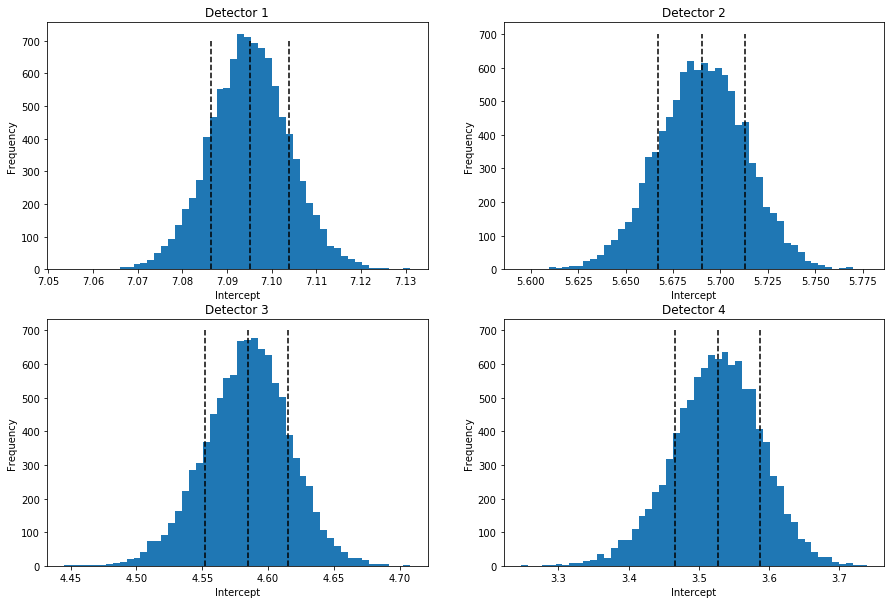

In [202]:
# Calculated median, upper(84%)/lower(16%) Confidence Intervals for bootstrap parameters
median_BS_c1 = np.quantile(BS_c1, 0.5) 
median_BS_c2 = np.quantile(BS_c2, 0.5)
median_BS_c3 = np.quantile(BS_c3, 0.5)
median_BS_c4 = np.quantile(BS_c4, 0.5)

upperCI_BS_c1 = np.quantile(BS_c1, 0.84)
upperCI_BS_c2 = np.quantile(BS_c2, 0.84)
upperCI_BS_c3 = np.quantile(BS_c3, 0.84)
upperCI_BS_c4 = np.quantile(BS_c4, 0.84)

lowerCI_BS_c1 = np.quantile(BS_c1, 0.16)
lowerCI_BS_c2 = np.quantile(BS_c2, 0.16)
lowerCI_BS_c3 = np.quantile(BS_c3, 0.16)
lowerCI_BS_c4 = np.quantile(BS_c4, 0.16)

# Plot histograms with median, upper(84%)/lower(16%) Confidence Intervals for bootstrap parameters
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.hist(BS_c1, 50)
plt.vlines(median_BS_c1, 0, 700, colors='black', linestyles='dashed')
plt.vlines(upperCI_BS_c1, 0, 700, colors='black', linestyles='dashed')
plt.vlines(lowerCI_BS_c1, 0, 700, colors='black', linestyles='dashed')
plt.ylabel('Frequency')
plt.xlabel('Intercept')
plt.title('Detector 1')

plt.subplot(2,2,2)
plt.hist(BS_c2, 50)
plt.vlines(median_BS_c2, 0, 700, colors='black', linestyles='dashed')
plt.vlines(upperCI_BS_c2, 0, 700, colors='black', linestyles='dashed')
plt.vlines(lowerCI_BS_c2, 0, 700, colors='black', linestyles='dashed')
plt.ylabel('Frequency')
plt.xlabel('Intercept')
plt.title('Detector 2')

plt.subplot(2,2,3)
plt.hist(BS_c3, 50)
plt.vlines(median_BS_c3, 0, 700, colors='black', linestyles='dashed')
plt.vlines(upperCI_BS_c3, 0, 700, colors='black', linestyles='dashed')
plt.vlines(lowerCI_BS_c3, 0, 700, colors='black', linestyles='dashed')
plt.ylabel('Frequency')
plt.xlabel('Intercept')
plt.title('Detector 3')

plt.subplot(2,2,4)
plt.hist(BS_c4, 50)
plt.vlines(median_BS_c4, 0, 700, colors='black', linestyles='dashed')
plt.vlines(upperCI_BS_c4, 0, 700, colors='black', linestyles='dashed')
plt.vlines(lowerCI_BS_c4, 0, 700, colors='black', linestyles='dashed')
plt.ylabel('Frequency')
plt.xlabel('Intercept')
plt.title('Detector 4')

In [203]:
# Print bootstrap intercepts for each detector with associated uncertainties
print('INTERCEPT\nDETECTOR 1: Median:', median_BS_c1, '+', upperCI_BS_c1-median_BS_c1, '-',median_BS_c1-lowerCI_BS_c1)
print('DETECTOR 2: Median:', median_BS_c2, '+', upperCI_BS_c2-median_BS_c2, '-',median_BS_c2-lowerCI_BS_c2)
print('DETECTOR 3: Median:', median_BS_c3, '+', upperCI_BS_c3-median_BS_c3, '-',median_BS_c3-lowerCI_BS_c3)
print('DETECTOR 4: Median:', median_BS_c4, '+', upperCI_BS_c4-median_BS_c4, '-',median_BS_c4-lowerCI_BS_c4)

INTERCEPT
DETECTOR 1: Median: 7.0950850212894245 + 0.00873336864144214 - 0.008637935360561677
DETECTOR 2: Median: 5.6904947922114495 + 0.022713044600444654 - 0.023619349154706093
DETECTOR 3: Median: 4.585168803075199 + 0.030237100660880145 - 0.03276621191930129
DETECTOR 4: Median: 3.5278783981408415 + 0.05905857049271246 - 0.062221001158834


In [204]:
# Calculate decay constant using modelled gradient for each detector + uncertainties
print('DETECTOR 1: Decay Constant:', -median_BS_m1, '+', upperCI_BS_m1-median_BS_m1, '-', median_BS_m1-lowerCI_BS_m1)
print('DETECTOR 2: Decay Constant:', -median_BS_m2, '+', upperCI_BS_m2-median_BS_m2, '-', median_BS_m2-lowerCI_BS_m2)
print('DETECTOR 3: Decay Constant:', -median_BS_m3, '+', upperCI_BS_m3-median_BS_m3, '-', median_BS_m3-lowerCI_BS_m3)
print('DETECTOR 4: Decay Constant:', -median_BS_m4, '+', upperCI_BS_m4-median_BS_m4, '-', median_BS_m4-lowerCI_BS_m4)

DETECTOR 1: Decay Constant: 0.038568493548237937 + 0.00012711916324266437 - 0.00012770175188902416
DETECTOR 2: Decay Constant: 0.03806833628870216 + 0.0003410519982701282 - 0.00033632204383808595
DETECTOR 3: Decay Constant: 0.03801773474646301 + 0.00047287485156611436 - 0.0004597599269164643
DETECTOR 4: Decay Constant: 0.033772137227363 + 0.0009072909052916175 - 0.0008961926636839174


In [205]:
# Calculate half-life using modelled gradient for each detector + uncertainties
HL1 = np.log(2)/(-median_BS_m1)
HL2 = np.log(2)/(-median_BS_m2)
HL3 = np.log(2)/(-median_BS_m3)
HL4 = np.log(2)/(-median_BS_m4)

e_upper_HL1 = ((upperCI_BS_m1-median_BS_m1)/(-median_BS_m1))*HL1
e_upper_HL2 = ((upperCI_BS_m2-median_BS_m2)/(-median_BS_m2))*HL2
e_upper_HL3 = ((upperCI_BS_m3-median_BS_m3)/(-median_BS_m3))*HL3
e_upper_HL4 = ((upperCI_BS_m4-median_BS_m4)/(-median_BS_m4))*HL4

e_lower_HL1 = ((median_BS_m1-lowerCI_BS_m1)/(-median_BS_m1))*HL1
e_lower_HL2 = ((median_BS_m2-lowerCI_BS_m2)/(-median_BS_m2))*HL2
e_lower_HL3 = ((median_BS_m3-lowerCI_BS_m3)/(-median_BS_m3))*HL3
e_lower_HL4 = ((median_BS_m4-lowerCI_BS_m4)/(-median_BS_m4))*HL4

print('DETECTOR 1: Half-Life:', HL1, '+', e_upper_HL1, '-', e_lower_HL1)
print('DETECTOR 2: Half-Life:', HL2, '+', e_upper_HL2, '-', e_lower_HL2)
print('DETECTOR 3: Half-Life:', HL3, '+', e_upper_HL3, '-', e_lower_HL3)
print('DETECTOR 4: Half-Life:', HL4, '+', e_upper_HL4, '-', e_lower_HL4)

DETECTOR 1: Half-Life: 17.971849994426677 + 0.05923401001796648 - 0.05950548019472459
DETECTOR 2: Half-Life: 18.207971456994194 + 0.1631241513356148 - 0.1608618282690544
DETECTOR 3: Half-Life: 18.2322062369703 + 0.22677710483085065 - 0.22048756620922114
DETECTOR 4: Half-Life: 20.524232028713325 + 0.551384975501609 - 0.5446402769255709


In [206]:
# Calculate A0 using modelled intercept for each detector + uncertainties
A01 = math.exp(median_BS_c1)
A02 = math.exp(median_BS_c2)
A03 = math.exp(median_BS_c3)
A04 = math.exp(median_BS_c4)

e_upper_A01 = A01*(upperCI_BS_c1-median_BS_c1)
e_upper_A02 = A02*(upperCI_BS_c2-median_BS_c2)
e_upper_A03 = A03*(upperCI_BS_c3-median_BS_c3)
e_upper_A04 = A04*(upperCI_BS_c4-median_BS_c4)

e_lower_A01 = A01*(median_BS_c1-lowerCI_BS_c1)
e_lower_A02 = A02*(median_BS_c2-lowerCI_BS_c2)
e_lower_A03 = A03*(median_BS_c3-lowerCI_BS_c3)
e_lower_A04 = A04*(median_BS_c4-lowerCI_BS_c4)

print('DETECTOR 1: A0:', A01, '+', e_upper_A01, '-', e_lower_A01)
print('DETECTOR 2: A0:', A02, '+', e_upper_A02, '-', e_lower_A02)
print('DETECTOR 3: A0:', A03, '+', e_upper_A03, '-', e_lower_A03)
print('DETECTOR 4: A0:', A04, '+', e_upper_A04, '-', e_lower_A04)

DETECTOR 1: A0: 1206.0248969237514 + 10.53266001559238 - 10.417565102855423
DETECTOR 2: A0: 296.0400627256084 + 6.723971148205176 - 6.992273605297237
DETECTOR 3: A0: 98.01973177783098 + 2.963832496518748 - 3.211735303705481
DETECTOR 4: A0: 34.051646886644114 + 2.0110415880478243 - 2.1187275603940896


Text(0.5, 0, 'Distance from Detector (m)')

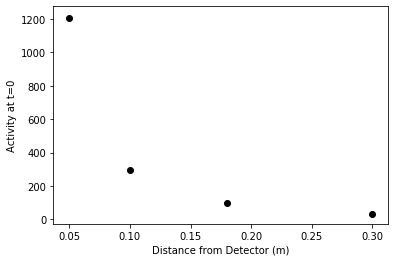

In [207]:
#Create arrays for A0 and detector distance and plot

# As upper and lower uncertainties were similar, I averaged them to make them easier to use
# in  my least squares and bootstrap functions
e_A01 = (e_upper_A01 + e_lower_A01) / 2
e_A02 = (e_upper_A02 + e_lower_A02) / 2
e_A03 = (e_upper_A03 + e_lower_A03) / 2
e_A04 = (e_upper_A04 + e_lower_A04) / 2

A0_array = np.array([A01, A02, A03, A04])
e_A0_array = np.array([e_A01, e_A02, e_A03, e_A04])

Dist_array = np.array([0.05, 0.1, 0.18, 0.3])
e_Dist_array = np.array([0.0005, 0.0005, 0.0005, 0.0005])

plt.errorbar(Dist_array, A0_array, yerr=e_A0_array, xerr=e_Dist_array, fmt='ko')
plt.ylabel('Activity at t=0')
plt.xlabel('Distance from Detector (m)')

Text(0.5, 1.0, 'Residuals')

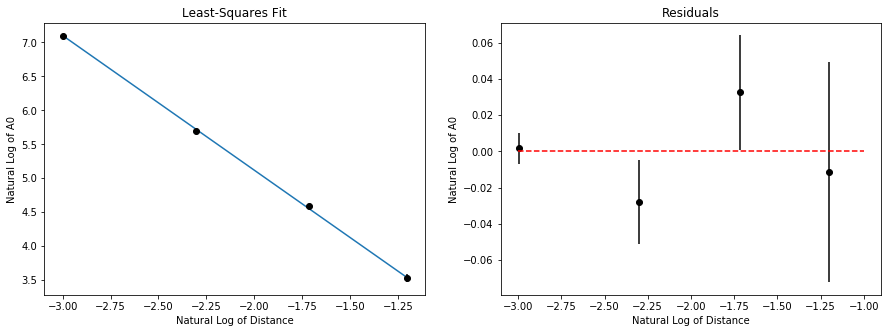

In [208]:
# Taking the natural log of activity at t=0, and distance from detector

# As upper and lower uncertainties were similar, I averaged them to make them easier to use
# in  my least squares and bootstrap functions
e_A01_ln = ((upperCI_BS_c1-median_BS_c1) + (median_BS_c1-lowerCI_BS_c1)) /2
e_A02_ln = ((upperCI_BS_c2-median_BS_c2) + (median_BS_c2-lowerCI_BS_c2)) /2
e_A03_ln = ((upperCI_BS_c3-median_BS_c3) + (median_BS_c3-lowerCI_BS_c3)) /2
e_A04_ln = ((upperCI_BS_c4-median_BS_c4) + (median_BS_c4-lowerCI_BS_c4)) /2

A0_array_ln = np.array([median_BS_c1, median_BS_c2, median_BS_c3, median_BS_c4])
e_A0_array_ln = np.array([e_A01_ln, e_A02_ln, e_A03_ln, e_A04_ln])

Dist_array_ln = np.log(Dist_array)
e_Dist_array_ln = e_Dist_array/Dist_array

# Creating least squares model for linear data and calculating residuals
m_powerlaw, c_powerlaw = WeightedLeastSquares(Dist_array_ln, A0_array_ln, e_A0_array_ln)
residuals_powerlaw = A0_array_ln-(m_powerlaw*Dist_array_ln + c_powerlaw)

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(Dist_array_ln, m_powerlaw*Dist_array_ln+c_powerlaw)
plt.errorbar(Dist_array_ln, A0_array_ln, yerr=e_A0_array_ln, xerr=e_Dist_array_ln, fmt='ko')
plt.ylabel('Natural Log of A0')
plt.xlabel('Natural Log of Distance')
plt.title('Least-Squares Fit')

plt.subplot(1,2,2)
plt.errorbar(Dist_array_ln, residuals_powerlaw, yerr=e_A0_array_ln, fmt='ko')
plt.hlines(0, -3, -1, colors='red', linestyles='dashed', zorder=3)
plt.ylabel('Natural Log of A0')
plt.xlabel('Natural Log of Distance')
plt.title('Residuals')

In [209]:
# Performing bootstrap analysis on least squares model to find uncertainties
BS_m_powerlaw, BS_c_powerlaw = BootStrap(residuals_powerlaw, Dist_array_ln, m_powerlaw, c_powerlaw, e_A0_array_ln, iterations)

median_m_powerlaw = np.quantile(BS_m_powerlaw, 0.5)
upperCI_m_powerlaw = np.quantile(BS_m_powerlaw, 0.84)
lowerCI_m_powerlaw = np.quantile(BS_m_powerlaw, 0.16)

median_c_powerlaw = np.quantile(BS_c_powerlaw, 0.5)
upperCI_c_powerlaw = np.quantile(BS_c_powerlaw, 0.84)
lowerCI_c_powerlaw = np.quantile(BS_c_powerlaw, 0.16)

print('Powerlaw Index:', median_m_powerlaw, '+', upperCI_m_powerlaw-median_m_powerlaw, '-', median_m_powerlaw-lowerCI_m_powerlaw)
print('Powerlaw Constant:', math.exp(median_c_powerlaw),'+', math.exp(median_c_powerlaw)*(upperCI_c_powerlaw-median_c_powerlaw), '-', math.exp(median_c_powerlaw)*(median_c_powerlaw-lowerCI_c_powerlaw))

Powerlaw Index: -1.9834469712202925 + 0.01921013800229865 - 0.01858848432376936
Powerlaw Constant: 3.1633491020958777 + 0.11407894082024121 - 0.12115536492345505


In [210]:
# Calculate number of particles in the sample and associated uncertainties
detector_CS = 3.142 / 10000
e_detector_CS = 0.001 / 10000

CS_fraction = detector_CS / (4*np.pi*Dist_array**2)
e_CS_fraction = CS_fraction*((e_detector_CS/detector_CS)**2 + (e_Dist_array/Dist_array)**2)**0.5

Source = A0_array / CS_fraction
e_Source = Source*((e_A0_array/A0_array)**2 + (e_CS_fraction/CS_fraction)**2)**0.5

DC_array = np.array([-median_BS_m1,-median_BS_m2,-median_BS_m3,-median_BS_m4])
e_DC_array = np.array([np.std(-median_BS_m1), np.std(-median_BS_m2), np.std(-median_BS_m3), np.std(-median_BS_m4)])

N0 = np.mean(Source / DC_array)
e_N0 = np.mean(N0*((e_Source/Source)**2 + (e_DC_array/DC_array)**2)**0.5)


print('Number of Particles:', N0, '+-', e_N0)

Number of Particles: 3301774.522976765 +- 106680.33780110156


In [211]:
# compare results with SciPy Optimise

popt1, pcov1 = curve_fit(SingleIsotope, t, R1, sigma=e_R1)
popt2, pcov2 = curve_fit(SingleIsotope, t, R2, sigma=e_R2)
popt3, pcov3 = curve_fit(SingleIsotope, t, R3, sigma=e_R3)
popt4, pcov4 = curve_fit(SingleIsotope, t, R4, sigma=e_R4)


print('DETECTOR 1: Decay Constant:', popt1[1],'+-', np.sqrt(pcov1[1][1]))
print('DETECTOR 2: Decay Constant:', popt2[1],'+-', np.sqrt(pcov2[1][1]))
print('DETECTOR 3: Decay Constant:', popt3[1],'+-', np.sqrt(pcov3[1][1]))
print('DETECTOR 4: Decay Constant:', popt4[1],'+-', np.sqrt(pcov4[1][1]))

print('\nDETECTOR 1: A0:', popt1[0],'+-', np.sqrt(pcov1[0][0]))
print('DETECTOR 2: A0:', popt2[0],'+-', np.sqrt(pcov2[0][0]))
print('DETECTOR 3: A0:', popt3[0],'+-', np.sqrt(pcov3[0][0]))
print('DETECTOR 4: A0:', popt4[0],'+-', np.sqrt(pcov4[0][0]))

print('\nDETECTOR 1: Half-Life:', np.log(2)/popt1[1],'+-', (np.sqrt(pcov1[1][1])/popt1[1])*(np.log(2)/popt1[1]))
print('DETECTOR 2: Half-Life:', np.log(2)/popt2[1],'+-', (np.sqrt(pcov2[1][1])/popt2[1])*(np.log(2)/popt2[1]))
print('DETECTOR 3: Half-Life:', np.log(2)/popt3[1],'+-', (np.sqrt(pcov3[1][1])/popt3[1])*(np.log(2)/popt3[1]))
print('DETECTOR 4: Half-Life:', np.log(2)/popt4[1],'+-', (np.sqrt(pcov4[1][1])/popt4[1])*(np.log(2)/popt4[1]))

DETECTOR 1: Decay Constant: 0.038893426756167505 +- 0.0002315365201232898
DETECTOR 2: Decay Constant: 0.039862637861266655 +- 0.0005664184522300314
DETECTOR 3: Decay Constant: 0.041476650694356555 +- 0.0008641223662940958
DETECTOR 4: Decay Constant: 0.03856337500260035 +- 0.0014835050219106111

DETECTOR 1: A0: 1210.6562615818495 +- 9.284799608558037
DETECTOR 2: A0: 302.2183023946785 +- 5.548666473034089
DETECTOR 3: A0: 101.42181626036775 +- 2.689095469873264
DETECTOR 4: A0: 33.88610162250114 +- 1.4926286732059766

DETECTOR 1: Half-Life: 17.821705063569123 +- 0.10609442050328131
DETECTOR 2: Half-Life: 17.388392182481628 +- 0.2470761273011515
DETECTOR 3: Half-Life: 16.711744293621496 +- 0.3481716045570417
DETECTOR 4: Half-Life: 17.974235411532472 +- 0.6914557788630777


C:\Users\btate\Anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: overflow encountered in multiply


In [212]:
########## Second Dataset ##########

In [213]:
# Calculate least squares fit for second data set
m1_2, c1_2 = WeightedLeastSquares(t_2, R1_2_ln, e_R1_2_ln)
m2_2, c2_2 = WeightedLeastSquares(t_2, R2_2_ln, e_R2_2_ln)
m3_2, c3_2 = WeightedLeastSquares(t_2, R3_2_ln, e_R3_2_ln)
m4_2, c4_2 = WeightedLeastSquares(t_2, R4_2_ln, e_R4_2_ln)

A01_2 = math.exp(c1_2)
A02_2 = math.exp(c2_2)
A03_2 = math.exp(c3_2)
A04_2 = math.exp(c4_2)

print('DETECTOR 1: A0:', A01_2)
print('DETECTOR 2: A0:', A02_2)
print('DETECTOR 3: A0:', A03_2)
print('DETECTOR 4: A0:', A04_2)

print('\nDETECTOR 1: Decay Constant:', -m1_2)
print('DETECTOR 2: Decay Constant:', -m2_2)
print('DETECTOR 3: Decay Constant:', -m3_2)
print('DETECTOR 4: Decay Constant:', -m4_2)

DETECTOR 1: A0: 3051.920358654646
DETECTOR 2: A0: 756.7227531573742
DETECTOR 3: A0: 240.3562385744596
DETECTOR 4: A0: 85.87433089693904

DETECTOR 1: Decay Constant: 0.017379912921459358
DETECTOR 2: Decay Constant: 0.01714513232709886
DETECTOR 3: Decay Constant: 0.017536589712960838
DETECTOR 4: Decay Constant: 0.017293736187996


In [214]:
## Calculate Residuals for each detector##
residuals1_2 = R1_2_ln-(m1_2*t + c1_2)
residuals2_2 = R2_2_ln-(m2_2*t + c2_2)
residuals3_2 = R3_2_ln-(m3_2*t + c3_2)
residuals4_2 = R4_2_ln-(m4_2*t + c4_2)

# Perform bootstrap analysis for each detector
iterations = 10000
BS_m1_2, BS_c1_2 = BootStrap(residuals1_2, t_2, m1_2, c1_2, e_R1_2_ln, iterations)
BS_m2_2, BS_c2_2 = BootStrap(residuals2_2, t_2, m2_2, c2_2, e_R2_2_ln, iterations)
BS_m3_2, BS_c3_2 = BootStrap(residuals3_2, t_2, m3_2, c3_2, e_R3_2_ln, iterations)
BS_m4_2, BS_c4_2 = BootStrap(residuals4_2, t_2, m4_2, c4_2, e_R4_2_ln, iterations)

# Calculated median, upper(84%)/lower(16%) Confidence Intervals for bootstrap parameters
median_BS_m1_2 = np.quantile(BS_m1_2, 0.5) 
median_BS_m2_2 = np.quantile(BS_m2_2, 0.5)
median_BS_m3_2 = np.quantile(BS_m3_2, 0.5)
median_BS_m4_2 = np.quantile(BS_m4_2, 0.5)

upperCI_BS_m1_2 = np.quantile(BS_m1_2, 0.84)
upperCI_BS_m2_2 = np.quantile(BS_m2_2, 0.84)
upperCI_BS_m3_2 = np.quantile(BS_m3_2, 0.84)
upperCI_BS_m4_2 = np.quantile(BS_m4_2, 0.84)

lowerCI_BS_m1_2 = np.quantile(BS_m1_2, 0.16)
lowerCI_BS_m2_2 = np.quantile(BS_m2_2, 0.16)
lowerCI_BS_m3_2 = np.quantile(BS_m3_2, 0.16)
lowerCI_BS_m4_2 = np.quantile(BS_m4_2, 0.16)

median_BS_c1_2 = np.quantile(BS_c1_2, 0.5) 
median_BS_c2_2 = np.quantile(BS_c2_2, 0.5)
median_BS_c3_2 = np.quantile(BS_c3_2, 0.5)
median_BS_c4_2 = np.quantile(BS_c4_2, 0.5)

upperCI_BS_c1_2 = np.quantile(BS_c1_2, 0.84)
upperCI_BS_c2_2 = np.quantile(BS_c2_2, 0.84)
upperCI_BS_c3_2 = np.quantile(BS_c3_2, 0.84)
upperCI_BS_c4_2 = np.quantile(BS_c4_2, 0.84)

lowerCI_BS_c1_2 = np.quantile(BS_c1_2, 0.16)
lowerCI_BS_c2_2 = np.quantile(BS_c2_2, 0.16)
lowerCI_BS_c3_2 = np.quantile(BS_c3_2, 0.16)
lowerCI_BS_c4_2 = np.quantile(BS_c4_2, 0.16)

In [215]:
# Calculate decay constant using modelled gradient for each detector + uncertainties
print('DETECTOR 1: Decay Constant:', -median_BS_m1_2, '+', upperCI_BS_m1_2-median_BS_m1_2, '-', median_BS_m1_2-lowerCI_BS_m1_2)
print('DETECTOR 2: Decay Constant:', -median_BS_m2_2, '+', upperCI_BS_m2_2-median_BS_m2_2, '-', median_BS_m2_2-lowerCI_BS_m2_2)
print('DETECTOR 3: Decay Constant:', -median_BS_m3_2, '+', upperCI_BS_m3_2-median_BS_m3_2, '-', median_BS_m3_2-lowerCI_BS_m3_2)
print('DETECTOR 4: Decay Constant:', -median_BS_m4_2, '+', upperCI_BS_m4_2-median_BS_m4_2, '-', median_BS_m4_2-lowerCI_BS_m4_2)

DETECTOR 1: Decay Constant: 0.017381555849063833 + 0.00012908894810775493 - 0.00012530690183435583
DETECTOR 2: Decay Constant: 0.01714900402637829 + 0.00017714738664892718 - 0.00017655033627238942
DETECTOR 3: Decay Constant: 0.017539193194620536 + 0.0002826770150679628 - 0.00028907035262452224
DETECTOR 4: Decay Constant: 0.017295201666678334 + 0.0004982705690761147 - 0.00048769840361106986


In [216]:
# Calculate A0 using modelled intercept for each detector + uncertainties
A01_BS_2 = math.exp(median_BS_c1_2)
A02_BS_2 = math.exp(median_BS_c2_2)
A03_BS_2 = math.exp(median_BS_c3_2)
A04_BS_2 = math.exp(median_BS_c4_2)

e_upper_A01_BS_2 = A01_BS_2*(upperCI_BS_c1_2-median_BS_c1_2)
e_upper_A02_BS_2 = A02_BS_2*(upperCI_BS_c2_2-median_BS_c2_2)
e_upper_A03_BS_2 = A03_BS_2*(upperCI_BS_c3_2-median_BS_c3_2)
e_upper_A04_BS_2 = A04_BS_2*(upperCI_BS_c4_2-median_BS_c4_2)

e_lower_A01_BS_2 = A01_BS_2*(median_BS_c1_2-lowerCI_BS_c1_2)
e_lower_A02_BS_2 = A02_BS_2*(median_BS_c2_2-lowerCI_BS_c2_2)
e_lower_A03_BS_2 = A03_BS_2*(median_BS_c3_2-lowerCI_BS_c3_2)
e_lower_A04_BS_2 = A04_BS_2*(median_BS_c4_2-lowerCI_BS_c4_2)

print('DETECTOR 1: A0:', A01_BS_2, '+', e_upper_A01_BS_2, '-', e_lower_A01_BS_2)
print('DETECTOR 2: A0:', A02_BS_2, '+', e_upper_A02_BS_2, '-', e_lower_A02_BS_2)
print('DETECTOR 3: A0:', A03_BS_2, '+', e_upper_A03_BS_2, '-', e_lower_A03_BS_2)
print('DETECTOR 4: A0:', A04_BS_2, '+', e_upper_A04_BS_2, '-', e_lower_A04_BS_2)

DETECTOR 1: A0: 3051.4805242990046 + 26.113280440546912 - 26.73406282100699
DETECTOR 2: A0: 756.9222442116261 + 9.147323239687832 - 9.448493270121805
DETECTOR 3: A0: 240.37525252016496 + 4.678504258812834 - 4.775913752159526
DETECTOR 4: A0: 85.92578277283822 + 2.805397544456532 - 3.0070296904197913


In [217]:
# Chi Squared grid around best fit values from least squares fit 

# +-10% of each parameter used for grid boundaries

##Detector 1##
m1_2_max = m1_2 + m1_2*0.1
m1_2_min = m1_2 - m1_2*0.1
m1_2_range = np.linspace(m1_2_min, m1_2_max, 100)
c1_2_max = c1_2 + c1_2*0.1
c1_2_min = c1_2 - c1_2*0.1
c1_2_range = np.linspace(c1_2_min, c1_2_max, 100)
chi_sq_1 = np.zeros((100, 100))

##Detector 2##
m2_2_max = m2_2 + m2_2*0.1
m2_2_min = m2_2 - m2_2*0.1
m2_2_range = np.linspace(m2_2_min, m2_2_max, 100)
c2_2_max = c2_2 + c2_2*0.1
c2_2_min = c2_2 - c2_2*0.1
c2_2_range = np.linspace(c2_2_min, c2_2_max, 100)
chi_sq_2 = np.zeros((100, 100))

##Detector 3##
m3_2_max = m3_2 + m3_2*0.1
m3_2_min = m3_2 - m3_2*0.1
m3_2_range = np.linspace(m3_2_min, m3_2_max, 100)
c3_2_max = c3_2 + c3_2*0.1
c3_2_min = c3_2 - c3_2*0.1
c3_2_range = np.linspace(c3_2_min, c3_2_max, 100)
chi_sq_3 = np.zeros((100, 100))

##Detector 4##
m4_2_max = m4_2 + m4_2*0.1
m4_2_min = m4_2 - m4_2*0.1
m4_2_range = np.linspace(m4_2_min, m4_2_max, 100)
c4_2_max = c4_2 + c4_2*0.1
c4_2_min = c4_2 - c4_2*0.1
c4_2_range = np.linspace(c4_2_min, c4_2_max, 100)
chi_sq_4 = np.zeros((100, 100))

# Nested for loop to calculate Chi Squared grid
for i in range(len(c1_2_range)):
    for j in range(len(m1_2_range)):
        r_calculated_1 = m1_2_range[j]*t_2 + c1_2_range[i]
        chi_sq_1[i][j] = ChiSquared(r_calculated_1, R1_2_ln, e_R1_2_ln)

for i in range(len(c2_2_range)):
    for j in range(len(m2_2_range)):
        r_calculated_2 = m2_2_range[j]*t_2 + c2_2_range[i]
        chi_sq_2[i][j] = ChiSquared(r_calculated_2, R2_2_ln, e_R2_2_ln)
        
for i in range(len(c3_2_range)):
    for j in range(len(m3_2_range)):
        r_calculated_3 = m3_2_range[j]*t_2 + c3_2_range[i]
        chi_sq_3[i][j] = ChiSquared(r_calculated_3, R3_2_ln, e_R3_2_ln)
        
for i in range(len(c4_2_range)):
    for j in range(len(m4_2_range)):
        r_calculated_4 = m4_2_range[j]*t_2 + c4_2_range[i]
        chi_sq_4[i][j] = ChiSquared(r_calculated_4, R4_2_ln, e_R4_2_ln)

Min Chi Squared for Detector 1: 255.56498486654414 when A0 is: 3076.7553696216937 and Decay Constant is: 0.01750280119464139
Min Chi Squared for Detector 2: 144.30463741646375 when A0 is: 761.8067378754622 and Decay Constant is: 0.017231723904508448
Min Chi Squared for Detector 3: 110.22015780843734 when A0 is: 241.6909024919875 and Decay Constant is: 0.017625158347874783
Min Chi Squared for Detector 4: 112.8463306974502 when A0 is: 85.4889472215832 and Decay Constant is: 0.017241330926820255


Text(0.5, 1.0, 'Detector 4')

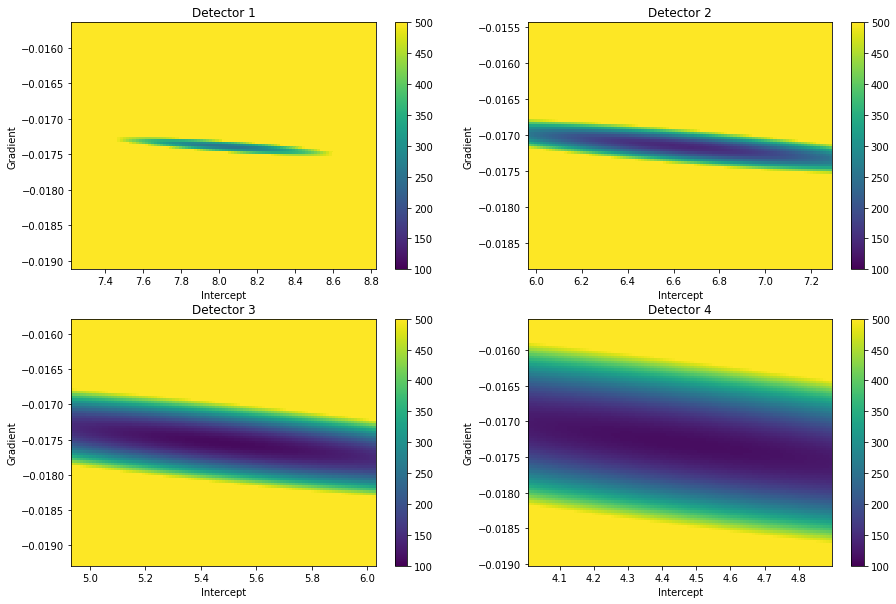

In [218]:
# Plot chi squared grids as heat maps

# Determine coordinates with minium chi square value
chi_sq_1_x = np.unravel_index(np.argmin(chi_sq_1), (100,100))[0]
chi_sq_1_y = np.unravel_index(np.argmin(chi_sq_1), (100,100))[1]
chi_sq_2_x = np.unravel_index(np.argmin(chi_sq_2), (100,100))[0]
chi_sq_2_y = np.unravel_index(np.argmin(chi_sq_2), (100,100))[1]
chi_sq_3_x = np.unravel_index(np.argmin(chi_sq_3), (100,100))[0]
chi_sq_3_y = np.unravel_index(np.argmin(chi_sq_3), (100,100))[1]
chi_sq_4_x = np.unravel_index(np.argmin(chi_sq_4), (100,100))[0]
chi_sq_4_y = np.unravel_index(np.argmin(chi_sq_4), (100,100))[1]

# Print minimum chi square values using coordinates above
print('Min Chi Squared for Detector 1:', chi_sq_1[chi_sq_1_x][chi_sq_1_y], 'when A0 is:',np.exp(c1_2_range[chi_sq_1_x]),'and Decay Constant is:',-m1_2_range[chi_sq_1_y])
print('Min Chi Squared for Detector 2:', chi_sq_2[chi_sq_2_x][chi_sq_2_x], 'when A0 is:',np.exp(c2_2_range[chi_sq_2_x]),'and Decay Constant is:',-m2_2_range[chi_sq_2_y])
print('Min Chi Squared for Detector 3:', chi_sq_3[chi_sq_3_x][chi_sq_3_x], 'when A0 is:',np.exp(c3_2_range[chi_sq_3_x]),'and Decay Constant is:',-m3_2_range[chi_sq_3_y])
print('Min Chi Squared for Detector 4:', chi_sq_4[chi_sq_4_x][chi_sq_4_x], 'when A0 is:',np.exp(c4_2_range[chi_sq_4_x]),'and Decay Constant is:',-m4_2_range[chi_sq_4_y])

# Plot heatmaps focused around minimum chi squared values
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.pcolormesh(c1_2_range, m1_2_range, chi_sq_1, vmin = 100,vmax=500)
plt.colorbar()
plt.ylabel('Gradient')
plt.xlabel('Intercept')
plt.title('Detector 1')

plt.subplot(2,2,2)
plt.pcolormesh(c2_2_range, m2_2_range, chi_sq_2, vmin = 100,vmax=500)
plt.colorbar()
plt.ylabel('Gradient')
plt.xlabel('Intercept')
plt.title('Detector 2')

plt.subplot(2,2,3)
plt.pcolormesh(c3_2_range, m3_2_range, chi_sq_3, vmin = 100,vmax=500)
plt.colorbar()
plt.ylabel('Gradient')
plt.xlabel('Intercept')
plt.title('Detector 3')

plt.subplot(2,2,4)
plt.pcolormesh(c4_2_range, m4_2_range, chi_sq_4, vmin = 100,vmax=500)
plt.colorbar()
plt.ylabel('Gradient')
plt.xlabel('Intercept')
plt.title('Detector 4')

In [219]:
# Calculate AIC and BIC of chi squared values

print('DETECTOR 1: AIC:',AIC_BIC(chi_sq_1[chi_sq_1_x][chi_sq_1_y], 100, 2)[0], 'BIC:', AIC_BIC(chi_sq_1[chi_sq_1_x][chi_sq_1_y], 100, 2)[1])
print('DETECTOR 2: AIC:',AIC_BIC(chi_sq_2[chi_sq_2_x][chi_sq_2_y], 100, 2)[0], 'BIC:', AIC_BIC(chi_sq_2[chi_sq_2_x][chi_sq_2_y], 100, 2)[1])
print('DETECTOR 3: AIC:',AIC_BIC(chi_sq_3[chi_sq_3_x][chi_sq_3_y], 100, 2)[0], 'BIC:', AIC_BIC(chi_sq_3[chi_sq_3_x][chi_sq_3_y], 100, 2)[1])
print('DETECTOR 4: AIC:',AIC_BIC(chi_sq_4[chi_sq_4_x][chi_sq_4_y], 100, 2)[0], 'BIC:', AIC_BIC(chi_sq_4[chi_sq_4_x][chi_sq_4_y], 100, 2)[1])

DETECTOR 1: AIC: 259.6886962067503 BIC: 264.77532523852034
DETECTOR 2: AIC: 147.71812976600663 BIC: 152.8047587977766
DETECTOR 3: AIC: 114.20211819139753 BIC: 119.28874722316753
DETECTOR 4: AIC: 116.94344738163508 BIC: 122.03007641340508


C:\Users\btate\Anaconda3\lib\site-packages\ipykernel_launcher.py:135: RuntimeWarning: overflow encountered in add


DETECTOR 1, Particle 1: Decay Const: 0.014490373637737105 +- 0.0008512409432958702 A0: 2322.556660394176 +- 250.2255226369519
DETECTOR 1, Particle 2: Decay Const: 0.04259179813644217 +- 0.008048757957808001 A0: 916.1401375543485 +- 238.34993045038962
DETECTOR 2, Particle 1: Decay Const: 0.012319141103872775 +- 0.0032241661110928104 A0: 442.57608176313175 +- 215.26182221196547
DETECTOR 2, Particle 2: Decay Const: 0.03359279175213068 +- 0.011474599170686398 A0: 361.84508077579846 +- 208.914753616191
DETECTOR 3, Particle 1: Decay Const: 0.016253943907393122 +- 0.0006904117177445253 A0: 214.6741034166942 +- 11.533985969682043
DETECTOR 3, Particle 2: Decay Const: 0.09736874324301756 +- 0.04083440522636594 A0: 53.00127220654535 +- 11.939843683585774
DETECTOR 4, Particle 1: Decay Const: 0.12005530212684686 +- 0.07778682009941047 A0: 20.874799620059417 +- 7.014542692830246
DETECTOR 4, Particle 2: Decay Const: 0.016352153237717954 +- 0.001025440436988573 A0: 76.1308975901634 +- 5.61584969090071

Text(0.5, 1.0, 'Detector 4')

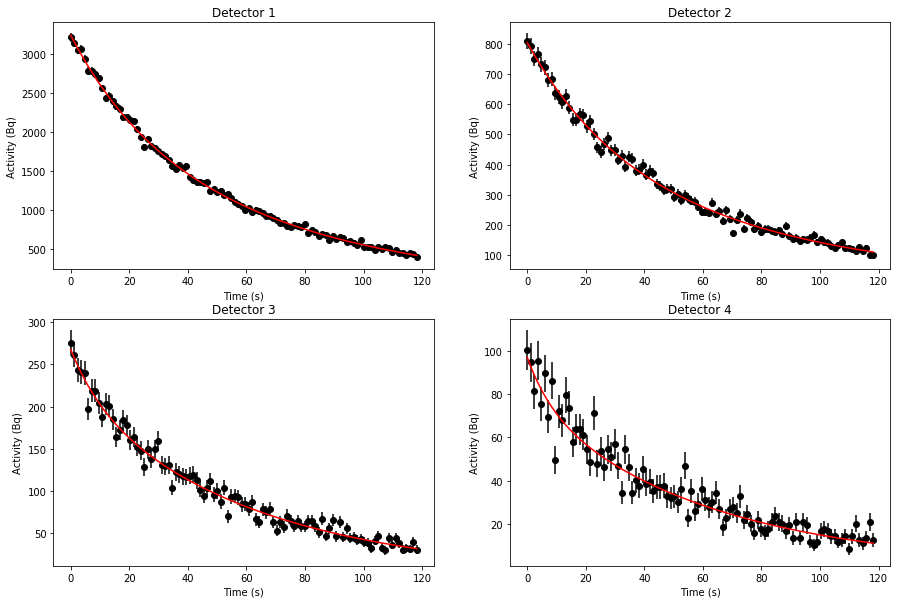

In [220]:
# Double isotope model using scipy curve fit 
popt1_2, pcov1_2 = curve_fit(DoubleIsotope, t_2, R1_2, sigma=e_R1_2)
popt2_2, pcov2_2 = curve_fit(DoubleIsotope, t_2, R2_2, sigma=e_R2_2)
popt3_2, pcov3_2 = curve_fit(DoubleIsotope, t_2, R3_2, sigma=e_R3_2)
popt4_2, pcov4_2 = curve_fit(DoubleIsotope, t_2, R4_2, sigma=e_R4_2)

print('DETECTOR 1, Particle 1: Decay Const:', popt1_2[2],'+-',np.sqrt(pcov1_2[2][2]),'A0:', popt1_2[0], '+-', np.sqrt(pcov1_2[0][0]))
print('DETECTOR 1, Particle 2: Decay Const:', popt1_2[3],'+-',np.sqrt(pcov1_2[3][3]),'A0:', popt1_2[1], '+-', np.sqrt(pcov1_2[1][1]))
print('DETECTOR 2, Particle 1: Decay Const:', popt2_2[3],'+-',np.sqrt(pcov2_2[3][3]),'A0:', popt2_2[1], '+-', np.sqrt(pcov2_2[1][1]))
print('DETECTOR 2, Particle 2: Decay Const:', popt2_2[2],'+-',np.sqrt(pcov2_2[2][2]),'A0:', popt2_2[0], '+-', np.sqrt(pcov2_2[0][0]))
print('DETECTOR 3, Particle 1: Decay Const:', popt3_2[3],'+-',np.sqrt(pcov3_2[3][3]),'A0:', popt3_2[1], '+-', np.sqrt(pcov3_2[1][1]))
print('DETECTOR 3, Particle 2: Decay Const:', popt3_2[2],'+-',np.sqrt(pcov3_2[2][2]),'A0:', popt3_2[0], '+-', np.sqrt(pcov3_2[0][0]))
print('DETECTOR 4, Particle 1: Decay Const:', popt4_2[2],'+-',np.sqrt(pcov4_2[2][2]),'A0:', popt4_2[0], '+-', np.sqrt(pcov4_2[0][0]))
print('DETECTOR 4, Particle 2: Decay Const:', popt4_2[3],'+-',np.sqrt(pcov4_2[3][3]),'A0:', popt4_2[1], '+-', np.sqrt(pcov4_2[1][1]))

plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(t_2, DoubleIsotope(t_2,*popt1_2), 'r-')
plt.errorbar(t_2, R1_2, yerr=e_R1_2, fmt='ko', zorder=1)
plt.ylabel('Activity (Bq)')
plt.xlabel('Time (s)')
plt.title('Detector 1')

plt.subplot(2,2,2)
plt.plot(t_2, DoubleIsotope(t_2,*popt2_2), 'r-')
plt.errorbar(t_2, R2_2, yerr=e_R2_2, fmt='ko', zorder=1)
plt.ylabel('Activity (Bq)')
plt.xlabel('Time (s)')
plt.title('Detector 2')

plt.subplot(2,2,3)
plt.plot(t_2, DoubleIsotope(t_2,*popt3_2), 'r-')
plt.errorbar(t_2, R3_2, yerr=e_R3_2, fmt='ko', zorder=1)
plt.ylabel('Activity (Bq)')
plt.xlabel('Time (s)')
plt.title('Detector 3')

plt.subplot(2,2,4)
plt.plot(t_2, DoubleIsotope(t_2,*popt4_2), 'r-')
plt.errorbar(t_2, R4_2, yerr=e_R4_2, fmt='ko', zorder=1)
plt.ylabel('Activity (Bq)')
plt.xlabel('Time (s)')
plt.title('Detector 4')

In [221]:
# Calculate step sizes for MCMC of each parameter
stepsize1 = np.array([np.sqrt(pcov1_2[0][0])*.125, np.sqrt(pcov1_2[1][1])*0.125, np.sqrt(pcov1_2[2][2])*0.125, np.sqrt(pcov1_2[3][3])*0.125])
stepsize2 = np.array([np.sqrt(pcov2_2[0][0])*.075, np.sqrt(pcov2_2[1][1])*0.075, np.sqrt(pcov2_2[2][2])*0.075, np.sqrt(pcov2_2[3][3])*0.075])
stepsize3 = np.array([np.sqrt(pcov3_2[0][0])*.75, np.sqrt(pcov3_2[1][1])*0.75, np.sqrt(pcov3_2[2][2])*0.75, np.sqrt(pcov3_2[3][3])*0.75])
stepsize4 = np.array([np.sqrt(pcov4_2[0][0])*.75, np.sqrt(pcov4_2[1][1])*0.75, np.sqrt(pcov4_2[2][2])*0.75, np.sqrt(pcov4_2[3][3])*0.75])

# Run MCMC for each detector
print('DETECTOR 1:')
chain1 = mcmc(DoubleIsotopeMCMC, t_2, R1_2, e_R1_2, popt1_2*1.1, stepsize1, 1000000)
print('DETECTOR 2:')
chain2 = mcmc(DoubleIsotopeMCMC, t_2, R2_2, e_R2_2, popt2_2*1.1, stepsize2, 1000000)
print('DETECTOR 3:')
chain3 = mcmc(DoubleIsotopeMCMC, t_2, R3_2, e_R3_2, popt3_2*1.1, stepsize3, 1000000)
print('DETECTOR 4:')
chain4 = mcmc(DoubleIsotopeMCMC, t_2, R4_2, e_R4_2, popt4_2*1.1, stepsize4, 1000000)

DETECTOR 1:
Jump fraction: 0.138
DETECTOR 2:
Jump fraction: 0.123
DETECTOR 3:
Jump fraction: 0.126
DETECTOR 4:
Jump fraction: 0.208


Text(0.5, 1.0, 'Isotope 2: Decay Constant')

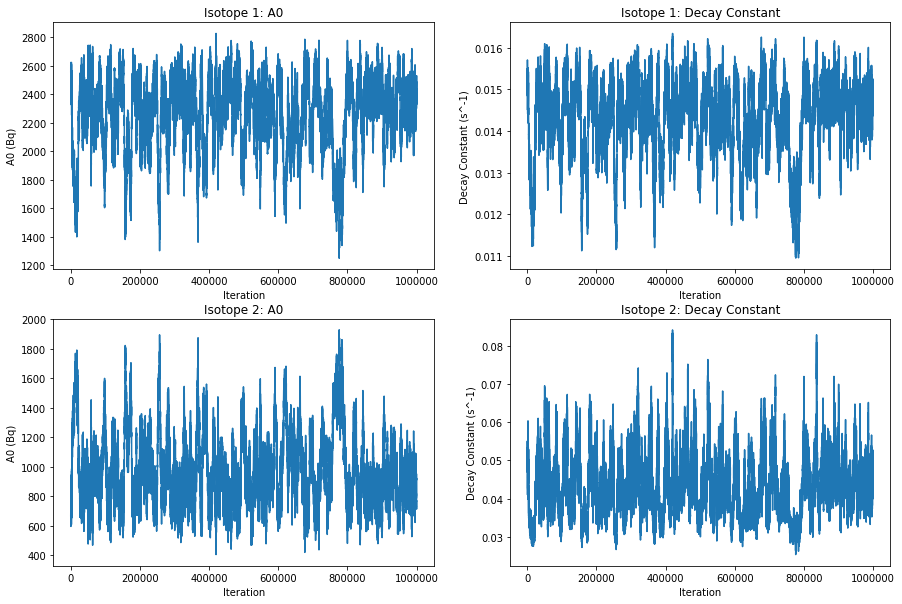

In [222]:
# Plot parameter chains for DETECTOR 1 
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(chain1[200:,0])
plt.ylabel('A0 (Bq)')
plt.xlabel('Iteration')
plt.title('Isotope 1: A0')

plt.subplot(2,2,2)
plt.plot(chain1[200:,2])
plt.ylabel('Decay Constant (s^-1)')
plt.xlabel('Iteration')
plt.title('Isotope 1: Decay Constant')

plt.subplot(2,2,3)
plt.plot(chain1[200:,1])
plt.ylabel('A0 (Bq)')
plt.xlabel('Iteration')
plt.title('Isotope 2: A0')

plt.subplot(2,2,4)
plt.plot(chain1[200:,3])
plt.ylabel('Decay Constant (s^-1)')
plt.xlabel('Iteration')
plt.title('Isotope 2: Decay Constant')

In [223]:
# Calculated median, upper(84%)/lower(16%) Confidence Intervals for MCMC Parameters for each detector

##DETECTOR 1##
median_MCMC_A01_1 = np.quantile(chain1[200:,0], 0.5)
median_MCMC_A02_1 = np.quantile(chain1[200:,1], 0.5)
median_MCMC_DC1_1 = np.quantile(chain1[200:,2], 0.5)
median_MCMC_DC2_1 = np.quantile(chain1[200:,3], 0.5)

upperCI_MCMC_A01_1 = np.quantile(chain1[200:,0], 0.84)
upperCI_MCMC_A02_1 = np.quantile(chain1[200:,1], 0.84)
upperCI_MCMC_DC1_1 = np.quantile(chain1[200:,2], 0.84)
upperCI_MCMC_DC2_1 = np.quantile(chain1[200:,3], 0.84)

lowerCI_MCMC_A01_1 = np.quantile(chain1[200:,0], 0.16)
lowerCI_MCMC_A02_1 = np.quantile(chain1[200:,1], 0.16)
lowerCI_MCMC_DC1_1 = np.quantile(chain1[200:,2], 0.16)
lowerCI_MCMC_DC2_1 = np.quantile(chain1[200:,3], 0.16)

##DETECTOR 2##
median_MCMC_A01_2 = np.quantile(chain2[200:,0], 0.5)
median_MCMC_A02_2 = np.quantile(chain2[200:,1], 0.5)
median_MCMC_DC1_2 = np.quantile(chain2[200:,2], 0.5)
median_MCMC_DC2_2 = np.quantile(chain2[200:,3], 0.5)

upperCI_MCMC_A01_2 = np.quantile(chain2[200:,0], 0.84)
upperCI_MCMC_A02_2 = np.quantile(chain2[200:,1], 0.84)
upperCI_MCMC_DC1_2 = np.quantile(chain2[200:,2], 0.84)
upperCI_MCMC_DC2_2 = np.quantile(chain2[200:,3], 0.84)

lowerCI_MCMC_A01_2 = np.quantile(chain2[200:,0], 0.16)
lowerCI_MCMC_A02_2 = np.quantile(chain2[200:,1], 0.16)
lowerCI_MCMC_DC1_2 = np.quantile(chain2[200:,2], 0.16)
lowerCI_MCMC_DC2_2 = np.quantile(chain2[200:,3], 0.16)

##DETECTOR 3##
median_MCMC_A01_3 = np.quantile(chain3[200:,0], 0.5)
median_MCMC_A02_3 = np.quantile(chain3[200:,1], 0.5)
median_MCMC_DC1_3 = np.quantile(chain3[200:,2], 0.5)
median_MCMC_DC2_3 = np.quantile(chain3[200:,3], 0.5)

upperCI_MCMC_A01_3 = np.quantile(chain3[200:,0], 0.84)
upperCI_MCMC_A02_3 = np.quantile(chain3[200:,1], 0.84)
upperCI_MCMC_DC1_3 = np.quantile(chain3[200:,2], 0.84)
upperCI_MCMC_DC2_3 = np.quantile(chain3[200:,3], 0.84)

lowerCI_MCMC_A01_3 = np.quantile(chain3[200:,0], 0.16)
lowerCI_MCMC_A02_3 = np.quantile(chain3[200:,1], 0.16)
lowerCI_MCMC_DC1_3 = np.quantile(chain3[200:,2], 0.16)
lowerCI_MCMC_DC2_3 = np.quantile(chain3[200:,3], 0.16)

##DETECTOR 4##
median_MCMC_A01_4 = np.quantile(chain4[200:,0], 0.5)
median_MCMC_A02_4 = np.quantile(chain4[200:,1], 0.5)
median_MCMC_DC1_4 = np.quantile(chain4[200:,2], 0.5)
median_MCMC_DC2_4 = np.quantile(chain4[200:,3], 0.5)

upperCI_MCMC_A01_4 = np.quantile(chain4[200:,0], 0.84)
upperCI_MCMC_A02_4 = np.quantile(chain4[200:,1], 0.84)
upperCI_MCMC_DC1_4 = np.quantile(chain4[200:,2], 0.84)
upperCI_MCMC_DC2_4 = np.quantile(chain4[200:,3], 0.84)

lowerCI_MCMC_A01_4 = np.quantile(chain4[200:,0], 0.16)
lowerCI_MCMC_A02_4 = np.quantile(chain4[200:,1], 0.16)
lowerCI_MCMC_DC1_4 = np.quantile(chain4[200:,2], 0.16)
lowerCI_MCMC_DC2_4 = np.quantile(chain4[200:,3], 0.16)

Text(0.5, 1.0, 'Isotope 2: Decay Constant')

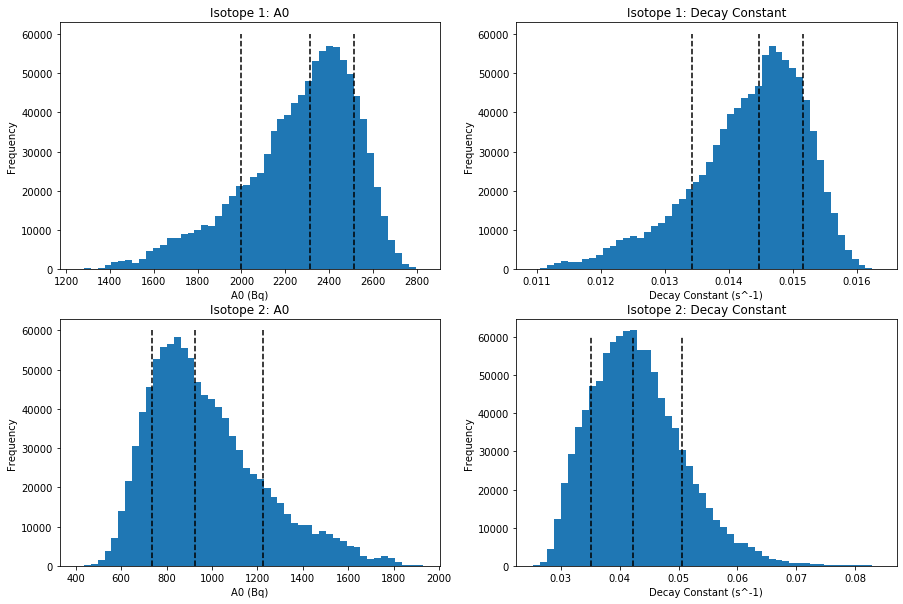

In [224]:
# Plot parameter histograms for DETECTOR 1 
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.hist(chain1[1000:,0],50)
plt.vlines(median_MCMC_A01_1, 0, 60000, colors='black', linestyles='dashed')
plt.vlines(upperCI_MCMC_A01_1, 0, 60000, colors='black', linestyles='dashed')
plt.vlines(lowerCI_MCMC_A01_1, 0, 60000, colors='black', linestyles='dashed')
plt.ylabel('Frequency')
plt.xlabel('A0 (Bq)')
plt.title('Isotope 1: A0')

plt.subplot(2,2,2)
plt.hist(chain1[1000:,2],50)
plt.vlines(median_MCMC_DC1_1, 0, 60000, colors='black', linestyles='dashed')
plt.vlines(upperCI_MCMC_DC1_1, 0, 60000, colors='black', linestyles='dashed')
plt.vlines(lowerCI_MCMC_DC1_1, 0, 60000, colors='black', linestyles='dashed')
plt.ylabel('Frequency')
plt.xlabel('Decay Constant (s^-1)')
plt.title('Isotope 1: Decay Constant')

plt.subplot(2,2,3)
plt.hist(chain1[1000:,1],50)
plt.vlines(median_MCMC_A02_1, 0, 60000, colors='black', linestyles='dashed')
plt.vlines(upperCI_MCMC_A02_1, 0, 60000, colors='black', linestyles='dashed')
plt.vlines(lowerCI_MCMC_A02_1, 0, 60000, colors='black', linestyles='dashed')
plt.ylabel('Frequency')
plt.xlabel('A0 (Bq)')
plt.title('Isotope 2: A0')

plt.subplot(2,2,4)
plt.hist(chain1[1000:,3],50)
plt.vlines(median_MCMC_DC2_1, 0, 60000, colors='black', linestyles='dashed')
plt.vlines(upperCI_MCMC_DC2_1, 0, 60000, colors='black', linestyles='dashed')
plt.vlines(lowerCI_MCMC_DC2_1, 0, 60000, colors='black', linestyles='dashed')
plt.ylabel('Frequency')
plt.xlabel('Decay Constant (s^-1)')
plt.title('Isotope 2: Decay Constant')

In [225]:
# Print Decay Constant and A0 values for Isotope 1 with their uncertainties

print('DETECTOR 1: Decay Constant:', median_MCMC_DC1_1, '+', upperCI_MCMC_DC1_1-median_MCMC_DC1_1, '-', median_MCMC_DC1_1-lowerCI_MCMC_DC1_1)
print('DETECTOR 2: Decay Constant:', median_MCMC_DC1_2, '+', upperCI_MCMC_DC1_2-median_MCMC_DC1_2, '-', median_MCMC_DC1_2-lowerCI_MCMC_DC1_2)
print('DETECTOR 3: Decay Constant:', median_MCMC_DC1_3, '+', upperCI_MCMC_DC1_3-median_MCMC_DC1_3, '-', median_MCMC_DC1_3-lowerCI_MCMC_DC1_3)
print('DETECTOR 4: Decay Constant:', median_MCMC_DC1_4, '+', upperCI_MCMC_DC1_4-median_MCMC_DC1_4, '-', median_MCMC_DC1_4-lowerCI_MCMC_DC1_4)

print('\nDETECTOR 1: A0:', median_MCMC_A01_1, '+', upperCI_MCMC_A01_1-median_MCMC_A01_1, '-', median_MCMC_A01_1-lowerCI_MCMC_A01_1)
print('DETECTOR 2: A0:', median_MCMC_A01_2, '+', upperCI_MCMC_A01_2-median_MCMC_A01_2, '-', median_MCMC_A01_2-lowerCI_MCMC_A01_2)
print('DETECTOR 3: A0:', median_MCMC_A01_3, '+', upperCI_MCMC_A01_3-median_MCMC_A01_3, '-', median_MCMC_A01_3-lowerCI_MCMC_A01_3)
print('DETECTOR 4: A0:', median_MCMC_A01_4, '+', upperCI_MCMC_A01_4-median_MCMC_A01_4, '-', median_MCMC_A01_4-lowerCI_MCMC_A01_4)

DETECTOR 1: Decay Constant: 0.01446371829517099 + 0.0006912212026544528 - 0.0010483802131909907
DETECTOR 2: Decay Constant: 0.03750157893467991 + 0.018414875355022522 - 0.00948609949265787
DETECTOR 3: Decay Constant: 0.14345481592888903 + 0.16481391722376415 - 0.07066682553542253
DETECTOR 4: Decay Constant: 10.08736308966443 + 14.421014856105158 - 7.5619525065557

DETECTOR 1: A0: 2313.740624081794 + 198.56314726818482 - 316.1531725739867
DETECTOR 2: A0: 302.33155012224114 + 188.04963461916765 - 115.97232708250132
DETECTOR 3: A0: 53.766082905053295 + 14.70069177573238 - 12.852112166734372
DETECTOR 4: A0: 17.76451565039216 + 9.246795394219124 - 9.45200418747607


In [226]:
# Print Decay Constant and A0 values for Isotope 2 with their uncertainties

print('DETECTOR 1: Decay Constant:', median_MCMC_DC2_1, '+', upperCI_MCMC_DC2_1-median_MCMC_DC2_1, '-', median_MCMC_DC2_1-lowerCI_MCMC_DC2_1)
print('DETECTOR 2: Decay Constant:', median_MCMC_DC2_2, '+', upperCI_MCMC_DC2_2-median_MCMC_DC2_2, '-', median_MCMC_DC2_2-lowerCI_MCMC_DC2_2)
print('DETECTOR 3: Decay Constant:', median_MCMC_DC2_3, '+', upperCI_MCMC_DC2_3-median_MCMC_DC2_3, '-', median_MCMC_DC2_3-lowerCI_MCMC_DC2_3)
print('DETECTOR 4: Decay Constant:', median_MCMC_DC2_4, '+', upperCI_MCMC_DC2_4-median_MCMC_DC2_4, '-', median_MCMC_DC2_4-lowerCI_MCMC_DC2_4)

print('\nDETECTOR 1: A0:', median_MCMC_A02_1, '+', upperCI_MCMC_A02_1-median_MCMC_A02_1, '-', median_MCMC_A02_1-lowerCI_MCMC_A02_1)
print('DETECTOR 2: A0:', median_MCMC_A02_2, '+', upperCI_MCMC_A02_2-median_MCMC_A02_2, '-', median_MCMC_A02_2-lowerCI_MCMC_A02_2)
print('DETECTOR 3: A0:', median_MCMC_A02_3, '+', upperCI_MCMC_A02_3-median_MCMC_A02_3, '-', median_MCMC_A02_3-lowerCI_MCMC_A02_3)
print('DETECTOR 4: A0:', median_MCMC_A02_4, '+', upperCI_MCMC_A02_4-median_MCMC_A02_4, '-', median_MCMC_A02_4-lowerCI_MCMC_A02_4)

DETECTOR 1: Decay Constant: 0.04220737003999664 + 0.00839079922755566 - 0.007099993947420627
DETECTOR 2: Decay Constant: 0.013236382287761823 + 0.0017817754592286822 - 0.0030933633347750376
DETECTOR 3: Decay Constant: 0.01666284962003104 + 0.0006004260540846129 - 0.0009686736212148363
DETECTOR 4: Decay Constant: 0.017612964999032147 + 0.000543674249524978 - 0.0005654041443135492

DETECTOR 1: A0: 925.105140907656 + 301.1974333639671 - 187.62398496390654
DETECTOR 2: A0: 504.3359409747114 + 124.34002735720907 - 194.21892625706278
DETECTOR 3: A0: 221.9473942866305 + 9.074061755266683 - 16.92797762128282
DETECTOR 4: A0: 83.17741945621276 + 2.2794637206611696 - 2.4354846422310317


In [227]:
# Calculate chi squared for parameters from MCMC chain
chi_sq_1_2isotope = ChiSquared(DoubleIsotope(t_2, median_MCMC_A01_1, median_MCMC_A02_1, median_MCMC_DC1_1, median_MCMC_DC2_1), R1_2, e_R1_2)
chi_sq_2_2isotope = ChiSquared(DoubleIsotope(t_2, median_MCMC_A01_2, median_MCMC_A02_2, median_MCMC_DC1_2, median_MCMC_DC2_2), R2_2, e_R2_2)
chi_sq_3_2isotope = ChiSquared(DoubleIsotope(t_2, median_MCMC_A01_3, median_MCMC_A02_3, median_MCMC_DC1_3, median_MCMC_DC2_3), R3_2, e_R3_2)
chi_sq_4_2isotope = ChiSquared(DoubleIsotope(t_2, median_MCMC_A01_4, median_MCMC_A02_4, median_MCMC_DC1_4, median_MCMC_DC2_4), R4_2, e_R4_2)

print('MCMC parameters Chi Squared for Detector 1:', chi_sq_1_2isotope)
print('MCMC parameters Chi Squared for Detector 2:', chi_sq_2_2isotope)
print('MCMC parameters Chi Squared for Detector 3:', chi_sq_3_2isotope)
print('MCMC parameters Chi Squared for Detector 4:', chi_sq_4_2isotope)

MCMC parameters Chi Squared for Detector 1: 91.65464062169184
MCMC parameters Chi Squared for Detector 2: 94.68611863252146
MCMC parameters Chi Squared for Detector 3: 91.25906832207376
MCMC parameters Chi Squared for Detector 4: 108.96847809145139


In [228]:
print('DETECTOR 1: AIC:',AIC_BIC(chi_sq_1_2isotope, 100, 4)[0], 'BIC:', AIC_BIC(chi_sq_1_2isotope, 100, 4)[1])
print('DETECTOR 1: AIC:',AIC_BIC(chi_sq_2_2isotope, 100, 4)[0], 'BIC:', AIC_BIC(chi_sq_2_2isotope, 100, 4)[1])
print('DETECTOR 1: AIC:',AIC_BIC(chi_sq_3_2isotope, 100, 4)[0], 'BIC:', AIC_BIC(chi_sq_3_2isotope, 100, 4)[1])
print('DETECTOR 1: AIC:',AIC_BIC(chi_sq_4_2isotope, 100, 4)[0], 'BIC:', AIC_BIC(chi_sq_4_2isotope, 100, 4)[1])

DETECTOR 1: AIC: 100.07569325327079 BIC: 110.07532136564421
DETECTOR 1: AIC: 103.1071712641004 BIC: 113.10679937647382
DETECTOR 1: AIC: 99.6801209536527 BIC: 109.67974906602612
DETECTOR 1: AIC: 117.38953072303033 BIC: 127.38915883540375


In [229]:
# Calculate half-life for first isotope
HL1_2_isotope1 = np.log(2)/(median_MCMC_DC1_1)
HL2_2_isotope1 = np.log(2)/(median_MCMC_DC1_2)
HL3_2_isotope1 = np.log(2)/(median_MCMC_DC1_3)
HL4_2_isotope1 = np.log(2)/(median_MCMC_DC1_4)
HL1_2_isotope1_upper = (np.sqrt((upperCI_MCMC_DC1_1-median_MCMC_DC1_1)/median_MCMC_DC1_1)*(np.log(2)/median_MCMC_DC1_1))
HL2_2_isotope1_upper = (np.sqrt((upperCI_MCMC_DC1_2-median_MCMC_DC1_2)/median_MCMC_DC1_2)*(np.log(2)/median_MCMC_DC1_2))
HL3_2_isotope1_upper = (np.sqrt((upperCI_MCMC_DC1_3-median_MCMC_DC1_3)/median_MCMC_DC1_3)*(np.log(2)/median_MCMC_DC1_3))
HL4_2_isotope1_upper = (np.sqrt((upperCI_MCMC_DC1_4-median_MCMC_DC1_4)/median_MCMC_DC1_4)*(np.log(2)/median_MCMC_DC1_4))
HL1_2_isotope1_lower = (np.sqrt((median_MCMC_DC1_1-lowerCI_MCMC_DC1_1)/median_MCMC_DC1_1)*(np.log(2)/median_MCMC_DC1_1))
HL2_2_isotope1_lower = (np.sqrt((median_MCMC_DC1_2-lowerCI_MCMC_DC1_2)/median_MCMC_DC1_2)*(np.log(2)/median_MCMC_DC1_2))
HL3_2_isotope1_lower = (np.sqrt((median_MCMC_DC1_3-lowerCI_MCMC_DC1_3)/median_MCMC_DC1_3)*(np.log(2)/median_MCMC_DC1_3))
HL4_2_isotope1_lower = (np.sqrt((median_MCMC_DC1_4-lowerCI_MCMC_DC1_4)/median_MCMC_DC1_4)*(np.log(2)/median_MCMC_DC1_4))

print('DETECTOR 1: Half-Life:',HL1_2_isotope1,'+',HL1_2_isotope1_upper,'-',HL1_2_isotope1_lower)
print('DETECTOR 2: Half-Life:',HL2_2_isotope1,'+',HL2_2_isotope1_upper,'-',HL2_2_isotope1_lower)
print('DETECTOR 3: Half-Life:',HL3_2_isotope1,'+',HL3_2_isotope1_upper,'-',HL3_2_isotope1_lower)
print('DETECTOR 4: Half-Life:',HL4_2_isotope1,'+',HL4_2_isotope1_upper,'-',HL4_2_isotope1_lower)


DETECTOR 1: Half-Life: 47.92316653397258 + 10.47644783304088 - 12.902234676434174
DETECTOR 2: Half-Life: 18.483146583434955 + 12.951960847551941 - 9.295975464661705
DETECTOR 3: Half-Life: 4.831815342494604 + 5.179045220314623 - 3.391255830985551
DETECTOR 4: Half-Life: 0.06871440775936259 + 0.08215933079424002 - 0.059494381469758835


In [230]:
# Calculate half-life for second isotope
HL1_2_isotope2 = np.log(2)/(median_MCMC_DC2_1)
HL2_2_isotope2 = np.log(2)/(median_MCMC_DC2_2)
HL3_2_isotope2 = np.log(2)/(median_MCMC_DC2_3)
HL4_2_isotope2 = np.log(2)/(median_MCMC_DC2_4)

HL1_2_isotope2_upper = (np.sqrt((upperCI_MCMC_DC2_1-median_MCMC_DC2_1)/median_MCMC_DC2_1)*(np.log(2)/median_MCMC_DC2_1))
HL2_2_isotope2_upper = (np.sqrt((upperCI_MCMC_DC2_2-median_MCMC_DC2_2)/median_MCMC_DC2_2)*(np.log(2)/median_MCMC_DC2_2))
HL3_2_isotope2_upper = (np.sqrt((upperCI_MCMC_DC2_3-median_MCMC_DC2_3)/median_MCMC_DC2_3)*(np.log(2)/median_MCMC_DC2_3))
HL4_2_isotope2_upper = (np.sqrt((upperCI_MCMC_DC2_4-median_MCMC_DC2_4)/median_MCMC_DC2_4)*(np.log(2)/median_MCMC_DC2_4))
HL1_2_isotope2_lower = (np.sqrt((median_MCMC_DC2_1-lowerCI_MCMC_DC2_1)/median_MCMC_DC2_1)*(np.log(2)/median_MCMC_DC2_1))
HL2_2_isotope2_lower = (np.sqrt((median_MCMC_DC2_2-lowerCI_MCMC_DC2_2)/median_MCMC_DC2_2)*(np.log(2)/median_MCMC_DC2_2))
HL3_2_isotope2_lower = (np.sqrt((median_MCMC_DC2_3-lowerCI_MCMC_DC2_3)/median_MCMC_DC2_3)*(np.log(2)/median_MCMC_DC2_3))
HL4_2_isotope2_lower = (np.sqrt((median_MCMC_DC2_4-lowerCI_MCMC_DC2_4)/median_MCMC_DC2_4)*(np.log(2)/median_MCMC_DC2_4))

print('DETECTOR 1: Half-Life:',HL1_2_isotope2,'+',HL1_2_isotope2_upper,'-',HL1_2_isotope2_lower)
print('DETECTOR 2: Half-Life:',HL2_2_isotope2,'+',HL2_2_isotope2_upper,'-',HL2_2_isotope2_lower)
print('DETECTOR 3: Half-Life:',HL3_2_isotope2,'+',HL3_2_isotope2_upper,'-',HL3_2_isotope2_lower)
print('DETECTOR 4: Half-Life:',HL4_2_isotope2,'+',HL4_2_isotope2_upper,'-',HL4_2_isotope2_lower)

DETECTOR 1: Half-Life: 16.422420537055583 + 7.322252280255706 - 6.735533684948189
DETECTOR 2: Half-Life: 52.36681485097478 + 19.2131244073699 - 25.315527147122598
DETECTOR 3: Half-Life: 41.598357805899354 + 7.896439518288037 - 10.029754095583572
DETECTOR 4: Half-Life: 39.35437222512135 + 6.914266818917043 - 7.051089815796029


(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [14.,  4., 56., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [54.,  5.,  0., ...,  0.,  0.,  0.]]),
 array([ 404.90622389,  420.14072653,  435.37522918,  450.60973182,
         465.84423447,  481.07873711,  496.31323976,  511.5477424 ,
         526.78224505,  542.01674769,  557.25125033,  572.48575298,
         587.72025562,  602.95475827,  618.18926091,  633.42376356,
         648.6582662 ,  663.89276885,  679.12727149,  694.36177413,
         709.59627678,  724.83077942,  740.06528207,  755.29978471,
         770.53428736,  785.76879   ,  801.00329265,  816.23779529,
         831.47229794,  846.70680058,  861.94130322,  877.17580587,
         892.41030851,  907.64481116,  922.8793138 ,  938.11381645,
         953.34831909,  968.58282174,  983.81732438,  999.05182702,
        1014.28632967, 1029.5208323

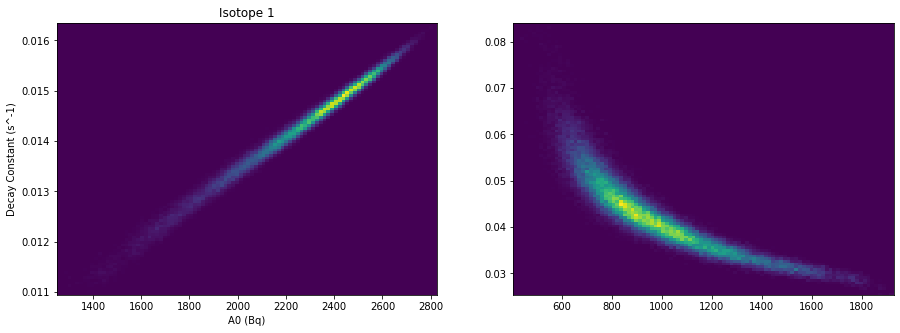

In [231]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.hist2d(chain1[1000:,0], chain1[1000:,2],100)
plt.ylabel('Decay Constant (s^-1)')
plt.xlabel('A0 (Bq)')
plt.title('Isotope 1')

plt.subplot(1,2,2)
plt.hist2d(chain1[1000:,1], chain1[1000:,3],100)

[3076.75536962  761.80673788  241.69090249   85.48894722]


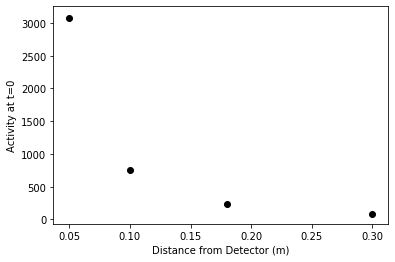

In [232]:
#Create arrays for A0 and detector distance and plot

# As upper and lower uncertainties were similar, I averaged them to make them easier to use
# in  my least squares and bootstrap functions
e_A01_2 = abs(np.exp(c1_2_range[chi_sq_1_x]) - A01_2)
e_A02_2 = abs(np.exp(c2_2_range[chi_sq_2_x]) - A02_2)
e_A03_2 = abs(np.exp(c3_2_range[chi_sq_3_x]) - A03_2)
e_A04_2 = abs(np.exp(c4_2_range[chi_sq_4_x]) - A04_2)

A0_2_array = np.array([np.exp(c1_2_range[chi_sq_1_x]), np.exp(c2_2_range[chi_sq_2_x]), np.exp(c3_2_range[chi_sq_3_x]), np.exp(c4_2_range[chi_sq_4_x])])
e_A0_2_array = np.array([e_A01_2, e_A02_2, e_A03_2, e_A04_2])

plt.errorbar(Dist_array, A0_2_array, yerr=e_A0_2_array, xerr=e_Dist_array, fmt='ko')
plt.ylabel('Activity at t=0')
plt.xlabel('Distance from Detector (m)')
print(A0_2_array)

Text(0.5, 1.0, 'Residuals')

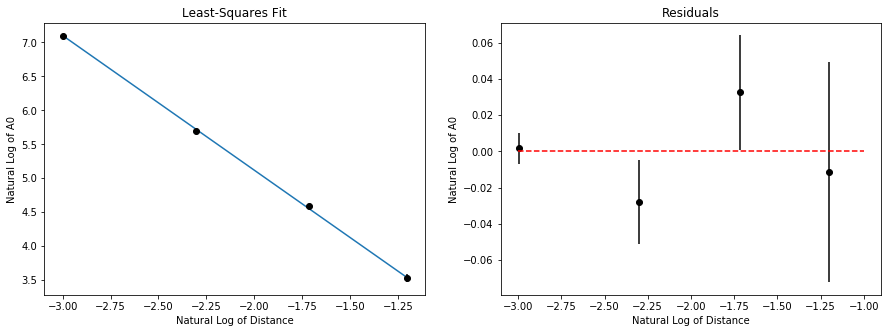

In [233]:
# Taking the natural log of activity at t=0, and distance from detector

e_A01_2_ln = e_A01_2 / A01_2
e_A02_2_ln = e_A02_2 / A02_2
e_A03_2_ln = e_A03_2 / A03_2
e_A04_2_ln = e_A04_2 / A04_2

A0_2_array_ln = np.log(A0_2_array)
e_A0_2_array_ln = np.array([e_A01_2_ln, e_A02_2_ln, e_A03_2_ln, e_A04_2_ln])

# Creating least squares model for linear data and calculating residuals
m_2_powerlaw, c_2_powerlaw = WeightedLeastSquares(Dist_array_ln, A0_2_array_ln, e_A0_2_array_ln)
residuals_2_powerlaw = A0_2_array_ln-(m_2_powerlaw*Dist_array_ln + c_2_powerlaw)

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(Dist_array_ln, m_powerlaw*Dist_array_ln+c_powerlaw)
plt.errorbar(Dist_array_ln, A0_array_ln, yerr=e_A0_array_ln, xerr=e_Dist_array_ln, fmt='ko')
plt.ylabel('Natural Log of A0')
plt.xlabel('Natural Log of Distance')
plt.title('Least-Squares Fit')

plt.subplot(1,2,2)
plt.errorbar(Dist_array_ln, residuals_powerlaw, yerr=e_A0_array_ln, fmt='ko')
plt.hlines(0, -3, -1, colors='red', linestyles='dashed', zorder=3)
plt.ylabel('Natural Log of A0')
plt.xlabel('Natural Log of Distance')
plt.title('Residuals')

In [234]:
# Performing bootstrap analysis on least squares model to find uncertainties
BS_m_2_powerlaw, BS_c_2_powerlaw = BootStrap(residuals_2_powerlaw, Dist_array_ln, m_2_powerlaw, c_2_powerlaw, e_A0_2_array_ln, iterations)

median_m_2_powerlaw = np.quantile(BS_m_2_powerlaw, 0.5)
upperCI_m_2_powerlaw = np.quantile(BS_m_2_powerlaw, 0.84)
lowerCI_m_2_powerlaw = np.quantile(BS_m_2_powerlaw, 0.16)

median_c_2_powerlaw = np.quantile(BS_c_2_powerlaw, 0.5)
upperCI_c_2_powerlaw = np.quantile(BS_c_2_powerlaw, 0.84)
lowerCI_c_2_powerlaw = np.quantile(BS_c_2_powerlaw, 0.16)

print('Powerlaw Index:', median_m_2_powerlaw, '+', upperCI_m_2_powerlaw-median_m_2_powerlaw, '-', median_m_2_powerlaw-lowerCI_m_2_powerlaw)
print('Powerlaw Constant:', math.exp(median_c_2_powerlaw),'+', math.exp(median_c_2_powerlaw)*(upperCI_c_2_powerlaw-median_c_2_powerlaw), '-', math.exp(median_c_2_powerlaw)*(median_c_2_powerlaw-lowerCI_c_2_powerlaw))

Powerlaw Index: -1.9965565030117247 + 0.00826133493878256 - 0.008492723452909079
Powerlaw Constant: 7.756046727828371 + 0.14981517417841145 - 0.11736557339342346


In [235]:
# Calculate number of particles in the 2 isotope sample and associated uncertainties
detector_CS_2 = 3.142 / 10000
e_detector_CS_2 = 0.001 / 10000

CS_fraction_2 = detector_CS_2 / (4*np.pi*Dist_array**2)
e_CS_fraction_2 = CS_fraction_2*((e_detector_CS_2/detector_CS_2)**2 + (e_Dist_array/Dist_array)**2)**0.5

Source_2 = A0_2_array / CS_fraction_2
e_Source_2 = Source_2*((e_A0_2_array/A0_2_array)**2 + (e_CS_fraction_2/CS_fraction_2)**2)**0.5

DC_2_array = np.array([-m1_2,-m2_2,-m3_2,-m4_2])
e_DC_2_array = np.array([np.std(-m1_2), np.std(-m2_2), np.std(-m3_2), np.std(-m4_2)])

N0_2 = np.mean(Source_2 / DC_2_array)
e_N0_2 = np.mean(N0_2*((e_Source_2/Source_2)**2 + (e_DC_2_array/DC_2_array)**2)**0.5)


print('Number of Particles:', N0_2, '+-', e_N0_2)

Number of Particles: 17781122.837561026 +- 143167.0914739958
